# Прогнозирование стоимости автомобиля
### Цель: обучить лучшую модель для предсказания цен на автомобили на auto.ru

### Задачи:

- Собрать тренировочный датасет/парсинг данных
- EDA и визуализация данных
- Поработать над очисткой и обогащением данных
- Оценить важность признаков для модели
- Обучить модель логистической регрессии
- Применить методы машинного обучения для улучшения прогнозирования цены автомобиля
- Настройка гиперпараметров модели
- Стэкинг
- Submission на Kaggle

### Описание датасета:

Данные - это набор характеристик автомобилей, выставленных на продажу: марка, дата выпуска модели, объем двигателя и т.д. Цена автомобиля является таргетом. Тренировочный датасет сформирован с помощью парсинга данных с сайта Auto.ru. Парсинг осуществлен с учетом признаков, имеющихся в тестовом датасете, всего 34686 наблюдений, и ограничен по году выпуска с 2005 по 2020 и статусами "с пробегом" и "продан". Всего в собранном тренировочном датасете 47423 наблюдений. Необходимо определить лучший алгоритм для предсказания цен на автомобили.

Предсказания цены автомобиля по различным характеристикам относится к задаче регрессии. Но необходимо будет определить лучший алгоритм для предсказания цен на автомобили.

In [350]:
import numpy as np
import pandas as pd 
import seaborn as sns
import sys
import matplotlib.pyplot as plt

import warnings
import re
import pandas_profiling
from nltk.util import ngrams
from collections import Counter
import xgboost as xgb

from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler, OrdinalEncoder, Binarizer, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression

import lightgbm as lgb
from datetime import timedelta, datetime, date

from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from prettytable import PrettyTable

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

In [351]:
RANDOM_SEED = 42
VAL_SIZE = 0.3
N_FOLDS    = 5

In [352]:
train = pd.read_csv('data/df_cars_final.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [353]:
# данные предоставлены двумя отдельными датасетами: тренировочный и тестовый.
# посмотрим на данные
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47423 entries, 0 to 47422
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              47423 non-null  object
 1   brand                 47423 non-null  object
 2   car_url               47423 non-null  object
 3   color                 47423 non-null  object
 4   complectation_dict    47423 non-null  object
 5   description           47423 non-null  object
 6   engineDisplacement    47423 non-null  object
 7   enginePower           47423 non-null  object
 8   equipment_dict        47423 non-null  object
 9   fuelType              47423 non-null  object
 10  image                 47423 non-null  object
 11  mileage               47423 non-null  int64 
 12  modelDate             47423 non-null  int64 
 13  model_info            47423 non-null  object
 14  model_name            47423 non-null  object
 15  name                  47423 non-null

(None, None)

In [354]:
train.columns, test.columns

(Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
        'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
        'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
        'name', 'numberOfDoors', 'parsing_unixtime', 'productionDate',
        'sell_id', 'super_gen', 'vehicleConfiguration', 'vehicleTransmission',
        'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
        'Таможня', 'price', 'priceCurrency'],
       dtype='object'),
 Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
        'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
        'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
        'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
        'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
        'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
        'Привод', 'Рул

## Подготовка данных
Переименуем столбцы в датасетах, чтобы они соответствовали друг другу

In [355]:
def col_change(df_input):
    df_output = df_input.copy()
    df_output = df_output.rename(
        columns={
            'bodyType':'body_type',
            'engineDisplacement':'engine_displacement',
            'enginePower':'engine_power',
            'fuelType':'fuel_type',
            'modelDate':'model_date', 
            'numberOfDoors': 'number_doors', 
            'priceCurrency': 'currency',
            'productionDate': 'production_date', 
            'vehicleConfiguration':'configuration',
            'vehicleTransmission':'transmission', 
            'parsing_unixtime': 'publish_unixtime',
            'Владельцы': 'car_owners',
            'Владение':'ownership',
            'ПТС':'pts',
            'Привод':'drive_type',
            'Руль': 'wheel',
            'Состояние':'condition',
            'Таможня':'customs'
        })
    return df_output

cols_to_drop = [] # список колонок для удаления из датасета

In [356]:
train = col_change(train)
test = col_change(test)
train.columns, test.columns

(Index(['body_type', 'brand', 'car_url', 'color', 'complectation_dict',
        'description', 'engine_displacement', 'engine_power', 'equipment_dict',
        'fuel_type', 'image', 'mileage', 'model_date', 'model_info',
        'model_name', 'name', 'number_doors', 'publish_unixtime',
        'production_date', 'sell_id', 'super_gen', 'configuration',
        'transmission', 'vendor', 'car_owners', 'ownership', 'pts',
        'drive_type', 'wheel', 'condition', 'customs', 'price', 'currency'],
       dtype='object'),
 Index(['body_type', 'brand', 'car_url', 'color', 'complectation_dict',
        'description', 'engine_displacement', 'engine_power', 'equipment_dict',
        'fuel_type', 'image', 'mileage', 'model_date', 'model_info',
        'model_name', 'name', 'number_doors', 'publish_unixtime', 'currency',
        'production_date', 'sell_id', 'super_gen', 'configuration',
        'transmission', 'vendor', 'car_owners', 'ownership', 'pts',
        'drive_type', 'wheel', 'condition

## Описание датасета

Поля датасета:
- body_type - тип кузова
- brand - марка автомобиля
- car_url - ссылка на автомобиля на сайте авто.ру
- color - цвет автомобиля
- complectation_dict - словарь с данными по комплектации автомобиля
- description - описание автомобиля
- engine_displacement - обдъем двигателя в литрах
- engine_power - мощность двигателя в л.с.
- equipment_dict - словарь с данными по оборудованию автомобиля
- fuel_type - тип топлива (бензин, дизель)
- image - ссылка на фото автомобиля
- mileage - пробег автомобиля в км
- model_date - год начало выпуска модели
- model_info - словарь с информацией по модели
- model_name - наименование модели
- name - наименование автомобиля
- number_doors - количество дверей
- parsing_unixtime - время и дата публикации в формате unixtime
- production_date - год выпуска автомобиля
- sell_id - идентификатор объявления
- super_gen - словарь дополнительной информации, например категория авто - премиум
- configuration - конфигурация автомобиля
- transmission- тип трансмиссии
- vendor - регион выпуска автомобиля
- car_owners - количество владельцев, может быть три значения: 1,2, 3 и более
- ownership - тип владения
- pts - вид ПТС, оригинал или дубликат
- drive_type - тип привода
- wheel - тип руля: правый или левый
- condition - состояние автомобиля
- customs - растаможен автомобиль или нет
- price - цена автомобиля
- currency - валюта стоимости автомобиля

### Осмотр обучаещего датасета

Осмотрим признак body_type

In [357]:
train.body_type.value_counts()

седан                      16614
внедорожник 5 дв.          15959
хэтчбек 5 дв.               6198
лифтбек                     2120
универсал 5 дв.             2086
компактвэн                   979
хэтчбек 3 дв.                909
минивэн                      898
купе                         635
внедорожник 3 дв.            326
фургон                       243
пикап двойная кабина         234
купе-хардтоп                 105
кабриолет                     56
родстер                       30
микровэн                      15
хэтчбек 4 дв.                  9
пикап одинарная кабина         3
пикап полуторная кабина        2
внедорожник открытый           2
Name: body_type, dtype: int64

<AxesSubplot:xlabel='body_type', ylabel='count'>

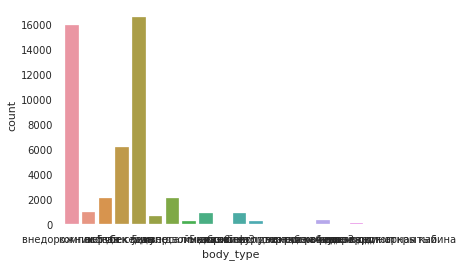

In [358]:
sns.countplot(x='body_type', data=train)

Категориальная переменная.

Осмотрим признак brand

In [359]:
train.brand.value_counts()

KIA             3500
HYUNDAI         3387
BMW             3276
MERCEDES        3175
VOLKSWAGEN      3008
NISSAN          2845
TOYOTA          2785
FORD            2626
VAZ             2527
CHEVROLET       2141
AUDI            2134
SKODA           2114
RENAULT         1930
OPEL            1761
MAZDA           1436
LAND_ROVER       967
LEXUS            865
PEUGEOT          862
VOLVO            793
DAEWOO           639
INFINITI         636
HONDA            634
CITROEN          600
UAZ              479
MITSUBISHI       446
SUZUKI           441
SUBARU           343
CHERY            273
GEELY            148
FIAT             129
ZAZ              108
GAZ               86
BENTLEY           85
CHRYSLER          82
SEAT              48
HUMMER            34
TESLA             32
ALFA_ROMEO        20
FERRARI           17
ASTON_MARTIN       7
GMC                4
Name: brand, dtype: int64

<AxesSubplot:xlabel='brand', ylabel='count'>

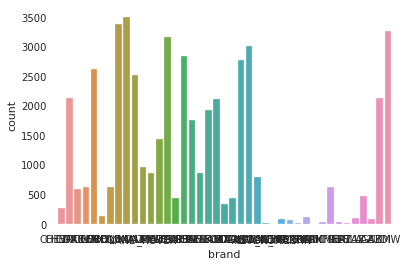

In [360]:
sns.countplot(x='brand', data=train)

Категориальная переменная.

Осмотрим признак car_url

In [361]:
train["car_url"].value_counts()

https://auto.ru/cars/used/sale/audi/a5/1103185751-90ca5a6e/              2
https://auto.ru/cars/used/sale/bmw/x5/1103038404-d04d179c/               2
https://auto.ru/cars/used/sale/hyundai/tucson/1102563935-be5fba05/       2
https://auto.ru/cars/used/sale/volkswagen/amarok/1102764881-b8124bdd/    2
https://auto.ru/cars/used/sale/nissan/almera/1103178703-d5b5509e/        2
                                                                        ..
https://auto.ru/cars/used/sale/land_rover/evoque/1103122901-5dbcdd34/    1
https://auto.ru/cars/used/sale/audi/a6/1102349299-983fe343/              1
https://auto.ru/cars/used/sale/vaz/2121/1103031258-d42dfc42/             1
https://auto.ru/cars/used/sale/volkswagen/tiguan/1102700119-c0380bfc/    1
https://auto.ru/cars/used/sale/chevrolet/lanos/1101146252-2952f766/      1
Name: car_url, Length: 47232, dtype: int64

Строка с адресом на объявление. Средни объявлений есть дубликаты. Очистим позже 

Осмотрим признак color

In [362]:
train["color"].value_counts()

чёрный         12884
белый           9847
серый           6368
серебристый     4895
синий           4119
коричневый      2492
красный         2461
бежевый         1129
зелёный          943
голубой          662
жёлтый           417
пурпурный        353
золотистый       297
оранжевый        291
фиолетовый       262
розовый            3
Name: color, dtype: int64

<AxesSubplot:xlabel='color', ylabel='count'>

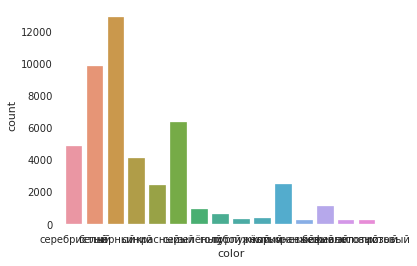

In [363]:
sns.countplot(x='color', data=train)

Категориальная переменная.

Осмотрим признак complectation_dict

In [364]:
train["complectation_dict"].value_counts()

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Словарь с признаками по комплектации  автомобиля. Требуется парсинг

Осмотрим признак description

In [365]:
train["description"].value_counts()

В РОЛЬФ Юг | Автомобили с пробегом только самые надёжные и проверенные автомобили!\n\nК Вашим услугам:\n\n✅ Гарантия юридической чистоты автомобиля.\n✅ Срочный выкуп автомобиля.\n✅ Выкуп кредитного автомобиля.\n✅ Технический осмотр кузова и салона, а также полная техническая диагностика автомобиля специалистами.\n✅ Обмен подержанных автомобилей на новый или автомобиль с пробегом.\n✅Автомобили хранятся на крытой, освещённой парковке\n\nПокупка автомобиля с пробегом в Рольф Юг — это:\n\n⭐Удобно — 5 минут от метро Калужская.\n⭐Быстро — сделка и оформление за 2 часа.\n⭐Выгодно — в кредит от 120 рублей в день.\n\nМы работаем ежедневно с 8:00 до 22:00 по адресу: Москва, улица Обручева, 27к1\n\n*Подробности в отделе продаж РОЛЬФ Юг                                                                                                                                                                                                                                                                          

Текстовое объявление от владельца. Можно поискать ключевые слова по тексту и создать новые признаки

Осмотрим признак engine_displacement

In [366]:
train.engine_displacement.value_counts()

1.6 LTR    13194
2.0 LTR     9488
1.4 LTR     3545
3.0 LTR     3350
1.8 LTR     2896
2.5 LTR     2332
1.5 LTR     1649
2.4 LTR     1557
3.5 LTR     1323
2.7 LTR      748
2.2 LTR      660
1.7 LTR      651
1.2 LTR      570
1.3 LTR      427
4.4 LTR      405
4.5 LTR      364
2.3 LTR      342
4.0 LTR      296
0.8 LTR      272
5.5 LTR      267
3.6 LTR      242
2.1 LTR      233
2.8 LTR      226
4.7 LTR      204
3.7 LTR      189
5.7 LTR      168
4.2 LTR      167
3.2 LTR      161
5.6 LTR      145
4.6 LTR      145
5.0 LTR      142
 LTR         121
1.0 LTR      119
6.0 LTR       99
2.9 LTR       95
1.9 LTR       90
3.8 LTR       81
6.2 LTR       73
5.3 LTR       68
0.7 LTR       54
3.1 LTR       50
3.3 LTR       43
4.8 LTR       41
1.1 LTR       28
5.4 LTR       22
4.1 LTR       20
5.9 LTR       15
6.3 LTR        8
4.3 LTR        8
6.8 LTR        7
6.6 LTR        5
3.4 LTR        4
5.2 LTR        3
3.9 LTR        3
6.1 LTR        2
2.6 LTR        2
6.5 LTR        2
0.9 LTR        1
5.8 LTR       

Числовая переменная. Информация по двигателям. Требуется очистка

Осмотрим признак engine_power

In [367]:
train.engine_power.value_counts()

150 N12    3835
249 N12    1975
140 N12    1602
105 N12    1516
123 N12    1496
           ... 
274 N12       1
660 N12       1
437 N12       1
284 N12       1
50 N12        1
Name: engine_power, Length: 352, dtype: int64

Категориальная переменная. Информация по мощности двигателя. Требуется очистка

Осмотрим признак equipment_dict

In [368]:
train.equipment_dict.value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Словарь с данными по оборудованию автомобиля. Требуется парсинг

Осмотрим признак fuel_type

In [369]:
train.fuel_type.value_counts()

бензин     40188
дизель      6901
гибрид       203
электро      121
газ           10
Name: fuel_type, dtype: int64

Категориальная переменная.

Осмотрим признак image

In [370]:
train.image.value_counts()

https://avatars.mds.yandex.net/get-verba/216201/2a000001609b62fdc53e55145a10f2ec6ecc/wizardv3mr                                                                                                                                  37
https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0812d7a913f263ae5fc3f1d8/wizardv3mr                                                                                                                                  29
https://avatars.mds.yandex.net/get-verba/787013/2a000001609ced211b658427648f8d8f24a5/wizardv3mr                                                                                                                                  27
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609d6e51de09bfd764df2598e1b0/wizardv3mr                                                                                                                                 24
https://avatars.mds.yandex.net/get-verba/787013/2a000001609c5392087e70561227a870e4bf/wiz

Строка с адресом на фото автомобиля. Среди ссылок есть дубликаты.

Осмотрим признак mileage

In [371]:
train.mileage.value_counts()

150000    451
200000    409
180000    385
160000    382
120000    360
         ... 
39896       1
99291       1
244700      1
46045       1
80          1
Name: mileage, Length: 17826, dtype: int64

Числовая характеристика. Характеризует пробег авто

Осмотрим признак model_date

In [372]:
train.model_date.value_counts()

2012    4004
2011    3834
2015    3586
2010    3542
2009    3487
2006    3278
2013    3103
2014    3076
2008    2566
2005    2544
2017    2431
2007    2412
2016    2055
2004    1826
2018    1309
2002     926
2003     781
2000     465
2001     373
2019     368
1993     260
2020     215
1997     190
1982     173
1994     155
1998     137
1999     123
1995      58
1979      51
1984      51
1987      22
1985      12
1992       3
1990       2
1976       2
1988       1
1972       1
1983       1
Name: model_date, dtype: int64

Числовая характеристика. Характеризует год начала производства авто

Осмотрим признак model_info

In [373]:
train.model_info.value_counts()

{'code': 'FOCUS', 'name': 'Focus', 'ru_name': 'Фокус', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                                     1468
{'code': 'SOLARIS', 'name': 'Solaris', 'ru_name': 'Солярис', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                               1056
{'code': 'OCTAVIA', 'name': 'Octavia', 'ru_name': 'Октавия', 'morphology': {'gender': 'FEMININE'}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}           1017
{'code': 'RIO', 'name': 'Rio', 'ru_name': 'Рио', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                                            873
{'code': 'CAMRY', 'name': 'Camry', 'ru_name': 'Камри', 'morphology': {'gender': 'FEMININE'}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                  740
                                                                                                                                       

Словарь с данными по модели автомобиля. Требуется парсинг

Осмотрим признак model_name

In [374]:
train.model_name.value_counts()

Ford Focus III                               465
Ford Focus II Рестайлинг                     429
Hyundai Solaris I Рестайлинг                 379
Volkswagen Polo V Рестайлинг                 368
Hyundai Solaris I                            355
                                            ... 
Volkswagen Transporter T5 Рестайлинг Long      1
Kia K5 I                                       1
Ford Tourneo Custom I Рестайлинг LWB           1
Aston Martin Rapide I (S)                      1
GMC Terrain II                                 1
Name: model_name, Length: 2428, dtype: int64

Строковая характеристика. Название модели автомобиля

Осмотрим признак name

In [375]:
train.name.value_counts()

1.6 MT     6479
2.0 AT     5694
1.6 AT     5117
3.0 AT     3164
1.4 MT     1675
           ... 
3.0 CVT       1
3.1 MT        1
3.5 MT        1
5.8 AT        1
4.7 AMT       1
Name: name, Length: 139, dtype: int64

Строковая характеристика. Есть информация по объему двигателя и типа коробки автомобиля. требуется парсинг

Осмотрим признак number_doors

In [376]:
train.number_doors.value_counts()

5    28007
4    17295
3     1286
2      835
Name: number_doors, dtype: int64

Числовая характеристика. Характеризует количество дверей в автомобиле

Осмотрим признак production_date

In [377]:
train.production_date.value_counts()

2012    4472
2013    4261
2011    3982
2008    3962
2014    3755
2017    3267
2016    3199
2018    3189
2007    3126
2015    2926
2010    2774
2019    2516
2006    2073
2009    1467
2005    1306
2020    1065
2021      83
Name: production_date, dtype: int64

Числовая характеристика. Характеризует год выпуска автомобиля

Осмотрим признак sell_id

In [378]:
train.sell_id.value_counts()

1102781444    2
1103154002    2
1103064711    2
1103116510    2
1102936357    2
             ..
1103121827    1
1102869924    1
1103068581    1
1103127974    1
1103169535    1
Name: sell_id, Length: 47232, dtype: int64

Уникальный индентификатор объявления. По нему как раз и будем чистить датасет

Осмотрим признак super_gen

In [379]:
train.super_gen.value_counts()

{'id': '7306596', 'name': 'III', 'ru_name': '3', 'year_from': 2011, 'year_to': 2015, 'price_segment': 'MEDIUM'}                                               465
{'id': '2308252', 'name': 'H Рестайлинг', 'year_from': 2006, 'year_to': 2014, 'price_segment': 'MEDIUM'}                                                      456
{'id': '2306579', 'name': 'II Рестайлинг', 'ru_name': '2 Рестайлинг', 'year_from': 2007, 'year_to': 2011, 'price_segment': 'MEDIUM'}                          429
{'id': '20162370', 'name': 'I Рестайлинг', 'ru_name': '1 Рестайлинг', 'year_from': 2014, 'year_to': 2017, 'price_segment': 'ECONOMY'}                         379
{'id': '20113124', 'name': 'V Рестайлинг', 'ru_name': '5 Рестайлинг', 'year_from': 2014, 'year_to': 2020, 'price_segment': 'ECONOMY'}                         368
                                                                                                                                                             ... 
{'id': '6298284', 'name': 'I

Дополнительный словарь с данными по автомобилю. Требуется парсинг

Осмотрим признак configuration

In [380]:
train.configuration.value_counts()

SEDAN MECHANICAL 1.6              2956
ALLROAD_5_DOORS AUTOMATIC 2.0     2739
SEDAN AUTOMATIC 1.6               2525
ALLROAD_5_DOORS AUTOMATIC 3.0     2315
SEDAN AUTOMATIC 2.0               2282
                                  ... 
CABRIO AUTOMATIC 1.8                 1
COUPE AUTOMATIC 4.6                  1
PICKUP_TWO MECHANICAL 1.7            1
LIFTBACK MECHANICAL 1.9              1
HATCHBACK_3_DOORS VARIATOR 2.0       1
Name: configuration, Length: 598, dtype: int64

Словарь с конфигурацией автомобиля. Хранит в себе тип (класс) автомобиля, тип КПП, объем двигателя. Требуется парсинг

Осмотрим признак transmission

In [381]:
train.transmission.value_counts()

автоматическая      25172
механическая        13968
роботизированная     4887
вариатор             3396
Name: transmission, dtype: int64

Категориальная переменная. Информация по КПП.

Осмотрим признак vendor

In [382]:
train.vendor.value_counts()

EUROPEAN    20926
JAPANESE    10431
KOREAN       7169
AMERICAN     4614
RUSSIAN      3862
CHINESE       421
Name: vendor, dtype: int64

Категориальная переменная. Информация по стране производителю.

Осмотрим признак car_owners

In [383]:
train.car_owners.value_counts()

1 владелец     17460
3 или более    16570
2 владельца    13393
Name: car_owners, dtype: int64

Числовая переменная. Информация по количеству владельцев. Есть пропуски.  

Осмотрим признак ownership

In [384]:
train.ownership.value_counts()

4 месяца              942
3 месяца              905
6 месяцев             845
5 месяцев             835
7 месяцев             800
                     ... 
15 лет и 8 месяцев      5
15 лет и 9 месяцев      4
15 лет и 4 месяца       3
14 лет и 6 месяцев      1
15 лет и 6 месяцев      1
Name: ownership, Length: 193, dtype: int64

Числовая переменная. Информация по длительности владения автомобилем. Требуется парсинг и перевод в месяцы

Осмотрим признак pts

In [385]:
train.pts.value_counts()

Оригинал    42751
Дубликат     4672
Name: pts, dtype: int64

Бинарная переменная. Оригинал ПТС или нет

Осмотрим признак drive_type

In [386]:
train.drive_type.value_counts()

передний    27604
полный      17069
задний       2750
Name: drive_type, dtype: int64

Категориальная переменная. Информация о типе привода автомобиля.

Осмотрим признак wheel

In [387]:
train.wheel.value_counts()

Левый     47105
Правый      318
Name: wheel, dtype: int64

Бинарная переменная. Левый руль или нет

Осмотрим признак condition

In [388]:
train.condition.value_counts()

Не требует ремонта    47422
Битый / не на ходу        1
Name: condition, dtype: int64

Бинарная переменная. Требуется ремонт или нет

Осмотрим признак customs

In [389]:
train.customs.value_counts()

Растаможен    47423
Name: customs, dtype: int64

Бинарная переменная. Растоможен автомобиль или нет

Осмотрим признак currency

In [390]:
train.currency.value_counts()

RUB    47423
Name: currency, dtype: int64

Категориальная переменная. Информация о валюте стоимости автомобиля.

Осмотрим признак price

In [391]:
train.price.value_counts()

650000     522
450000     497
750000     433
550000     420
350000     415
          ... 
4880000      1
1423000      1
4405000      1
1775500      1
2605000      1
Name: price, Length: 4278, dtype: int64

Целевая переменная. Стоимость автомобиля

### Осмотр тестового датасета

In [392]:
test.body_type.value_counts()

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап полуторная кабина        5
пикап одинарная кабина         5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: body_type, dtype: int64

<AxesSubplot:xlabel='body_type', ylabel='count'>

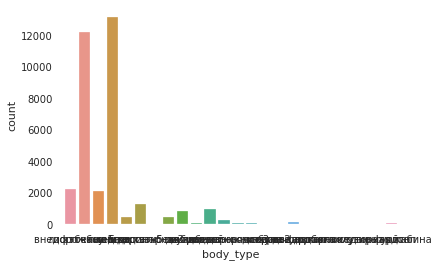

In [393]:
sns.countplot(x='body_type', data=test)

Категориальная переменная.

Осмотрим признак brand

In [394]:
test.brand.value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

<AxesSubplot:xlabel='brand', ylabel='count'>

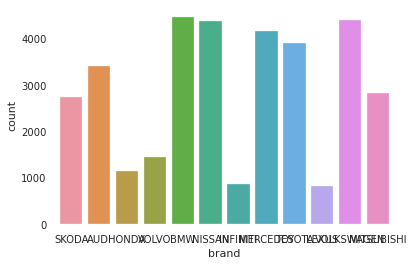

In [395]:
sns.countplot(x='brand', data=test)

Категориальная переменная.

Осмотрим признак car_url

In [396]:
test["car_url"].value_counts()

https://auto.ru/cars/used/sale/volkswagen/transporter/1101140502-abd86b9b/       1
https://auto.ru/cars/used/sale/mercedes/s_class_maybach/1100211818-2a2b6d20/     1
https://auto.ru/cars/used/sale/skoda/felicia/1101137180-779141d6/                1
https://auto.ru/cars/used/sale/nissan/avenir/1101174173-b3b2feb2/                1
https://auto.ru/cars/used/sale/bmw/5er/1099950952-1901f7da/                      1
                                                                                ..
https://auto.ru/cars/used/sale/toyota/mark_ii/1101361483-ae5e3cd7/               1
https://auto.ru/cars/used/sale/bmw/x6/1101350108-4973fac2/                       1
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1096938334-005068f8/    1
https://auto.ru/cars/used/sale/mitsubishi/grandis/1093777844-eae6ec78/           1
https://auto.ru/cars/used/sale/toyota/prius/1101188088-c2f461bf/                 1
Name: car_url, Length: 34686, dtype: int64

Строка с адресом на объявление. Очистим позже 

Осмотрим признак color

In [397]:
test["color"].value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

<AxesSubplot:xlabel='color', ylabel='count'>

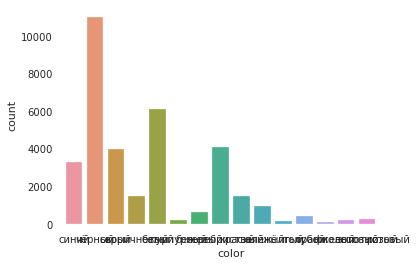

In [398]:
sns.countplot(x='color', data=test)

Категориальная переменная.

Осмотрим признак complectation_dict

In [399]:
test["complectation_dict"].value_counts()

{"id":"4562904","name":"Elegance","available_options":["cruise-control","multi-wheel","airbag-passenger","lock","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","audiopreparation","electro-window-back","condition","music-super","park-assist-r","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","alarm","ptf","rain-sensor","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo"]}                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Словарь с признаками по комплектации  автомобиля. Есть пропуски. Требуется парсинг

Осмотрим признак description

In [400]:
test["description"].value_counts()

Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. \n-В наличии более 500 проверенных и готовых к продаже автомобилей. \n-Более 400 комплектов шин, дисков, колес в сборе. \n-Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. \n-Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. \n-Мы работаем каждый день с 9:00 до 22:00 (без выходных). \nУслуги: \n• Срочный выкуп Вашего автомобиля \n• Выкуп кредитных а/м \n• Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) \n• Выездная оценка Вашего а/м \n• Комиссионная продажа (на Ваших условиях) \n• Аукцион \n• Кредитование \n• Страхование КАСКО, ОСАГО \n• Дополнительное оборудова

Текстовое объявление от владельца. Можно поискать ключевые слова по тексту и создать новые признаки

Осмотрим признак engine_displacement

In [401]:
test.engine_displacement.value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
3.8 LTR      57
1.0 LTR      57
2.6 LTR      55
 LTR         55
0.7 LTR      53
6.0 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
5.3 LTR       1
3.9 LTR       1
Name: engine_displacement, dtype: int64

Числовая переменная. Информация по двигателям. Требуется очистка

Осмотрим признак engine_power

In [402]:
test.engine_power.value_counts()

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
431 N12       1
514 N12       1
321 N12       1
301 N12       1
591 N12       1
Name: engine_power, Length: 315, dtype: int64

Категориальная переменная. Информация по мощности двигателя. Требуется очистка

Осмотрим признак equipment_dict

In [403]:
test.equipment_dict.value_counts()

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Словарь с данными по оборудованию автомобиля. Есть пропуски. Требуется парсинг

Осмотрим признак fuel_type

In [404]:
test.fuel_type.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuel_type, dtype: int64

Категориальная переменная.

Осмотрим признак image

In [405]:
test.image.value_counts()

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr                                                                                                                                  13
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr                                                                                                                                   9
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d6c09eb305345ee1ea7e7bd15/wizardv3mr                                                                                                                                   8
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr                                                                                                                                  8
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wiz

Строка с адресом на фото автомобиля. Среди ссылок есть дубликаты.

Осмотрим признак mileage

In [406]:
test.mileage.value_counts()

200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
152129      1
4681        1
461386      1
121424      1
69630       1
Name: mileage, Length: 11268, dtype: int64

Числовая характеристика. Характеризует пробег авто

Осмотрим признак model_date

In [407]:
test.model_date.value_counts()

2010    2503
2013    2275
2008    2243
2011    2173
2006    2169
        ... 
1965       1
1934       1
1973       1
1904       1
1969       1
Name: model_date, Length: 66, dtype: int64

Числовая характеристика. Характеризует год начала производства авто

Осмотрим признак model_info

In [408]:
test.model_info.value_counts()

{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}    1404
{"code":"LANCER","name":"Lancer","ru_name":"Лансер","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}                           843
{"code":"PASSAT","name":"Passat","ru_name":"Пассат","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}                           776
{"code":"A6","name":"A6","ru_name":"А6","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}                                       757
{"code":"POLO","name":"Polo","ru_name":"Поло","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}                                 724
                                                                                                                                                  ... 
{"code":"LM","name":"LM","ru_name":"ЛМ","morphology":{},"nameplate":{"code":"","name":"","sema

Словарь с данными по модели автомобиля. Требуется парсинг

Осмотрим признак model_name

In [409]:
test.model_name.value_counts()

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
            ... 
HS             1
VELLFIRE       1
POLO_GTI       1
OTTI           1
TORNEO         1
Name: model_name, Length: 544, dtype: int64

Строковая характеристика. Название модели автомобиля

Осмотрим признак name

In [410]:
test.name.value_counts()

1.6 AT (110 л.с.)            631
1.6 MT (102 л.с.)            410
1.6 MT (110 л.с.)            314
2.0 CVT (141 л.с.) 4WD       309
1.4 AMT (122 л.с.)           308
                            ... 
2.2 AT (136 л.с.)              1
1.4 MT (70 л.с.)               1
2.5d AT (95 л.с.) 4WD          1
460 4.6 AT (370 л.с.) 4WD      1
5.6 AT (405 л.с.)              1
Name: name, Length: 2780, dtype: int64

Строковая характеристика. Есть информация по объему двигателя и типа коробки автомобиля, мощности и (опционально) типу привода. Требуется парсинг

Осмотрим признак number_doors

In [411]:
test.number_doors.value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: number_doors, dtype: int64

Числовая характеристика. Характеризует количество дверей в автомобиле

Осмотрим признак production_date

In [412]:
test.production_date.value_counts()

2012    2798
2008    2606
2011    2589
2013    2488
2014    2134
        ... 
1968       1
1938       1
1970       1
1939       1
1952       1
Name: production_date, Length: 69, dtype: int64

Числовая характеристика. Характеризует год выпуска автомобиля

Осмотрим признак sell_id

In [413]:
test.sell_id.value_counts()

1092026368    1
1101243105    1
1101251456    1
1100827388    1
1101209406    1
             ..
1100538350    1
1101317650    1
1101281119    1
1101149708    1
1095774202    1
Name: sell_id, Length: 34686, dtype: int64

Уникальный индентификатор объявления.

Осмотрим признак super_gen

In [414]:
test.super_gen.value_counts()

{"id":"6214876","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":105,"power_kvt":77,"human_name":"1.6 MT (105 л.с.)","acceleration":10.5,"clearance_min":170,"fuel_rate":6.5}                                                  193
{"id":"20726520","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":110,"power_kvt":81,"human_name":"1.6 AT (110 л.с.)","acceleration":11.7,"clearance_min":163,"fuel_rate":5.9}                                                  159
{"id":"4561004","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":152,"power_kvt":112,"human_name":"1.8 AT (152 л.с.)","acceleration":8.8,"clearance_min":164,"fuel_rate":7.7}                                                   148
{"id":"7277667","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"VARIATOR","power":117,"pow

Дополнительный словарь с данными по автомобилю. Требуется парсинг

Осмотрим признак configuration

In [415]:
test.configuration.value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0       2389
SEDAN AUTOMATIC 2.0                 1610
ALLROAD_5_DOORS AUTOMATIC 2.0       1327
ALLROAD_5_DOORS VARIATOR 2.0        1323
SEDAN MECHANICAL 1.6                1314
                                    ... 
ROADSTER MECHANICAL 1.6                1
HATCHBACK_3_DOORS MECHANICAL 3.2       1
PICKUP_ONE_HALF AUTOMATIC 5.7          1
LIMOUSINE AUTOMATIC 6.0                1
ALLROAD_5_DOORS AUTOMATIC              1
Name: configuration, Length: 634, dtype: int64

Словарь с конфигурацией автомобиля. Хранит в себе тип (класс) автомобиля, тип КПП, объем двигателя. Требуется парсинг

Осмотрим признак transmission

In [416]:
test.transmission.value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: transmission, dtype: int64

Категориальная переменная. Информация по КПП.

Осмотрим признак vendor

In [417]:
test.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

Категориальная переменная. Информация по стране производителю.

Осмотрим признак car_owners

In [418]:
test.car_owners.value_counts()

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: car_owners, dtype: int64

Числовая переменная. Информация по количеству владельцев. Есть пропуски.  

Осмотрим признак ownership

In [419]:
test.ownership.value_counts()

1 год и 10 месяцев     209
2 года                 197
1 год                  194
1 год и 1 месяц        193
1 год и 2 месяца       187
                      ... 
20 лет                   1
16 лет и 5 месяцев       1
18 лет и 2 месяца        1
26 лет и 3 месяца        1
22 года и 9 месяцев      1
Name: ownership, Length: 275, dtype: int64

Числовая переменная. Информация по длительности владения автомобилем. Присутствуют пропуски. Требуется парсинг и перевод в месяцы

Осмотрим признак pts

In [420]:
test.pts.value_counts()

Оригинал    30098
Дубликат     4587
Name: pts, dtype: int64

Бинарная переменная. Оригинал ПТС или нет

Осмотрим признак drive_type

In [421]:
test.drive_type.value_counts()

передний    15565
полный      15020
задний       4101
Name: drive_type, dtype: int64

Категориальная переменная. Информация о типе привода автомобиля.

Осмотрим признак wheel

In [422]:
test.wheel.value_counts()

Левый     33287
Правый     1399
Name: wheel, dtype: int64

Бинарная переменная. Левый руль или нет

Осмотрим признак condition

In [423]:
test.condition.value_counts()

Не требует ремонта    34686
Name: condition, dtype: int64

Бинарная переменная. Требуется ремонт или нет

Осмотрим признак customs

In [424]:
test.customs.value_counts()

Растаможен    34686
Name: customs, dtype: int64

Бинарная переменная. Растоможен автомобиль или нет

Осмотрим признак currency

In [425]:
test.currency.value_counts()

RUB    34686
Name: currency, dtype: int64

Категориальная переменная. Информация о валюте стоимости автомобиля.

### Итоги

Как видно из описаний датасета при одинаковых полях в некоторых данные отличаются и требуется их очистка. Проведем предобработку отдельно для каждого сета и потом соединим их

Трейн датасет состоит и 33 признакoв, в том числе целевая переменная 'price', из них 25 признаков в виде строк, а 6 числовые. Задача прогнозирования цены автомобиля по его характеристикам является задачей логистической регрессии. Строковые признаки необходимо преобразовать. Будем преобразовать в списки. В 'ownership', 'complectation_dict', 'equipment_dict' и 'pts' есть пропуски, которые будем заполнять.

Сразу можно удалить столбцы с изображением, обозначением валюты, и ссылкой на авто и др., так как они не будут влиять на прогноз стоимости.

In [426]:
to_drop = [
    'car_url', 'image', 'currency', 'publish_unixtime', 'ownership'
]
for col in to_drop:
    cols_to_drop.append(col)

## Используемые функции

In [427]:
# функция удаления столбцов
def drop_columns(cols):
    for col in cols:
        train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

# функция, показывающая распределение данных
def column_info(column):
    print('Информация о столбце {}'.format(column))
    print(f'Количество пустых строк: {data[column].isnull().sum()}')
    print('Распределение столбца:', pd.DataFrame(data[column].value_counts()))
    print(data[column].describe())
    if data[column].dtype == 'int64' or data[column].dtype == 'float64':
        median = data[column].median()
        perc25 = data[column].quantile(0.25)
        perc75 = data[column].quantile(0.75)
        IQR = perc75 - perc25
        print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75},IQR: {IQR} Границы выбросов: [{perc25 - 1.5*IQR},{perc75 + 1.5*IQR}]')
        data[column].hist(bins = 10, label = 'IQR')
        plt.legend()
    print('\n')

# функция для удаления выбросов
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

# функция определения класса авто по модели
def model_segment(x):
    if x in model_3:
        return 3 #  премиум класс
    elif x in model_2:
        return 2 # средний класс
    else:
        return 1 # эконом класс

# метрика в виде функции
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Обработка и очистка данных

### Обработка признаков
Заполняем пропуски в 'pts' в тесте

In [428]:
# заполним пропуски наиболее часто встречающимся значением
test['pts'].fillna('Оригинал', inplace=True)

# присвоим числовые значения каждому типу 
pts_dict = {'Оригинал':1, 'Дубликат':0}
train.pts = train.pts.replace(to_replace=pts_dict)
test.pts = test.pts.replace(to_replace=pts_dict)

In [429]:
# заполним пропуски значением 'other'
test['equipment_dict'] = test['equipment_dict'].fillna("['other']")

# посчитаем количество указанных в описании комплектации машины хар-к
# если в признаке не строка, значит информации о комплектации нет
test['equipment_dict'] = test['equipment_dict'].apply(
    lambda x: len(x[1:-1].split(',')) if type(x == str) else 0)
train['equipment_dict'] = train['equipment_dict'].apply(
    lambda x: len(x[1:-1].split(',')) if type(x == str) else 0)

In [430]:
# Заполняем пропуски в 'complectation_dict'
# там где указана комплектация ставим 1, если нет -  0
test['complectation_d'] = test['complectation_dict'].notnull()
test['complectation_dict'] = test['complectation_d'].map({False:0, True: 1})

test.drop('complectation_d', axis=1, inplace=True)

train['complectation_d'] = train['complectation_dict'].notnull()
train['complectation_dict'] = train['complectation_d'].map({False:0, True: 1})

train.drop('complectation_d', axis=1, inplace=True)

Обработаем признак 'body_type'

всего 24 уникальных наименования, больше всего седанов.

In [431]:
#  Train dataset
train['body_type'] = train['body_type'].apply(lambda x: str(x))
def bodytype(row):
    for body_type in ['внедорожник', 'хэтчбек', 'купе-хардтоп', 'седан', 'универсал', 
                      'родстер', 'кабриолет', 'компактвэн', 'лифтбек', 'купе']:
        if row.lower().startswith(body_type):
            return body_type
train['body_type'] = train['body_type'].apply(bodytype)
train['body_type'] = train['body_type'].apply(lambda x: 'купе' if x == 'купе-хардтоп' else x)

# приведем к единому виду
train.body_type = train.body_type.str.lower()

#  test dataset
test['body_type'] = test['body_type'].apply(lambda x: str(x))
def bodytype(row):
    for body_type in ['внедорожник', 'хэтчбек', 'купе-хардтоп', 'седан', 'универсал', 
                      'родстер', 'кабриолет', 'компактвэн', 'лифтбек', 'купе']:
        if row.lower().startswith(body_type):
            return body_type
test['body_type'] = test['body_type'].apply(bodytype)
test['body_type'] = test['body_type'].apply(lambda x: 'купе' if x == 'купе-хардтоп' else x)
test['body_type'] = test['body_type'].str.lower()

#заменим пустые значения неизвестные 
train['body_type'].fillna('unknown', inplace=True)
test['body_type'].fillna('unknown', inplace=True)

Обработаем признак 'brands'

всего 14 уникальных наименования, больше всего BMW.

In [432]:
print(f'{len(test.brand.value_counts())} уникальных бренда в тесте и {len(train.brand.value_counts())} бренда в трейне')

12 уникальных бренда в тесте и 41 бренда в трейне


In [433]:
# формируем список из марок, как в тесте, остальное обозначим как "other"

car_list = ['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA',
            'AUDI', 'MITSUBISHI', 'SKODA', 'VOLVO', 'HONDA', 'INFINITI']

train['brand'] = np.where(train['brand'].isin(
    car_list), train['brand'], 'other')

Обработаем признак 'color'

всего 16 уникальных наименования, больше всего черных автомобилей.

In [434]:
# формируем список из популярных цветов, остальное обозначим как "other"

color_list = ['чёрный', 'белый', 'серый', 'серебристый', 'синий', 'коричневый',
        'красный', 'бежевый']
#  train dataset
train['color'] = np.where(train['color'].isin(
    color_list), train['color'], 'other')

#  test dataset
test['color'] = np.where(test['color'].isin(
    color_list), test['color'], 'other')

#  создадим новый признак - самый популярный цвет -1, остальное - 0
train['pop_color'] = train.color.apply(lambda x: 1 if x in color_list else 0)
test['pop_color'] = test.color.apply(lambda x: 1 if x in color_list else 0)

Обработаем признак 'description'

в данном поле много разных признаков которые можно выделить

In [435]:
train.description = train.description.apply(lambda x: x.lower())
test.description = test.description.apply(lambda x: x.lower())

# смотрим на самые частые слова в объявлениях
text = ' '.join(test['description'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(50)
my_list[:20]

# for test
test['new'] = test.description.apply(lambda x: 1 if 'нов' in x else 0)
test['full'] = test.description.apply(lambda x: 1 if ('полная' in x) or ('полный' in x)  else 0)
test['bargain'] = test.description.apply(lambda x: 1 if 'торг' in x else 0)
test['dealer'] = test.description.apply(lambda x: 1 if 'дилер' in x else 0)
test['exchange'] = test.description.apply(lambda x: 1 if 'обмен' in x else 0)
test['urgent'] = test.description.apply(lambda x: 1 if 'срочно' in x else 0)
test['discount'] = test.description.apply(lambda x: 1 if 'скидка' in x else 0)
test['extra'] = test.description.apply(lambda x: 1 if 'подарок' in x else 0)
test['tires'] = test.description.apply(lambda x: 1 if ('шины' in x) or ('резина' in x) else 0)
test['rims'] = test.description.apply(lambda x: 1 if 'диск' in x else 0)
test['heating'] = test.description.apply(lambda x: 1 if 'подогрев сидений' in x else 0)
test['service_incl'] = test.description.apply(lambda x: 1 if 'обслуживание' in x else 0)
test['central_lock'] = test.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
test['power_windows'] = test.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
test['computer'] = test.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)
test['airbag'] = test.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
test['power_steering'] = test.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)
test['cruise_control '] = test.description.apply(lambda x: 1 if 'круиз-контроль' in x else 0)
test['parking_sensors'] = test.description.apply(lambda x: 1 if 'парктроник' in x else 0)
test['child_car_seat'] = test.description.apply(lambda x: 1 if 'крепления детских автокресел' in x else 0)
test['good'] = test.description.apply(lambda x: 1 if 'хорош' in x else 0)
test['perfect'] = test.description.apply(lambda x: 1 if 'идеальн' in x else 0)
test['very_good'] = test.description.apply(lambda x: 1 if 'отлич' in x else 0)
#  для трейна
train['new'] = train.description.apply(lambda x: 1 if 'нов' in x else 0)
train['full'] = train.description.apply(lambda x: 1 if ('полная' in x) or ('полный' in x)  else 0)
train['bargain'] = train.description.apply(lambda x: 1 if 'торг' in x else 0)
train['dealer'] = train.description.apply(lambda x: 1 if 'дилер' in x else 0)
train['exchange'] = train.description.apply(lambda x: 1 if 'обмен' in x else 0)
train['urgent'] = train.description.apply(lambda x: 1 if 'срочно' in x else 0)
train['discount'] = train.description.apply(lambda x: 1 if 'скидка' in x else 0)
train['extra'] = train.description.apply(lambda x: 1 if 'подарок' in x else 0)
train['tires'] = train.description.apply(lambda x: 1 if ('шины' in x) or ('резина' in x) else 0)
train['rims'] = train.description.apply(lambda x: 1 if 'диск' in x else 0)
train['heating'] = train.description.apply(lambda x: 1 if 'подогрев сидений' in x else 0)
train['service_incl'] = train.description.apply(lambda x: 1 if 'обслуживание' in x else 0)
train['central_lock'] = train.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
train['power_windows'] = train.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
train['computer'] = train.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)
train['airbag'] = train.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
train['power_steering'] = train.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)
train['cruise_control '] = train.description.apply(lambda x: 1 if 'круиз-контроль' in x else 0)
train['parking_sensors'] = train.description.apply(lambda x: 1 if 'парктроник' in x else 0)
train['child_car_seat'] = train.description.apply(lambda x: 1 if 'крепления детских автокресел' in x else 0)
train['good'] = train.description.apply(lambda x: 1 if 'хорош' in x else 0)
train['perfect'] = train.description.apply(lambda x: 1 if 'идеальн' in x else 0)
train['very_good'] = train.description.apply(lambda x: 1 if 'отлич' in x else 0)
cols_to_drop.append('description')

In [436]:
train['condition'].value_counts()

Не требует ремонта    47422
Битый / не на ходу        1
Name: condition, dtype: int64

Обработаем признак 'engine_displacement'

уникальных значений 56, требуется преобразование значений - отсечение наименования LTR, самое частотное значение: 2.0 LTR

In [437]:
# преобразуем формат значения
train['engine_displacement'] = train['engine_displacement'].apply(lambda x: x[:3])
test['engine_displacement'] = test['engine_displacement'].apply(lambda x: x[:3])

In [438]:
# среди числовых значений есть LT
len(test[test['engine_displacement'] == ' LT']), len(train[train['engine_displacement'] == ' LT'])

(55, 121)

In [439]:
# заменим LT на наиболее частое 2.0
test['engine_displacement'] = test['engine_displacement'].apply(lambda x: 2.0 if x == ' LT' else x)
train['engine_displacement'] = train['engine_displacement'].apply(lambda x: 2.0 if x == ' LT' else x)

Обработаем признак 'engine_power'

In [440]:
# преобразуем формат значения
test['engine_power'] = test['engine_power'].apply(lambda x: x[:3])
train['engine_power'] = train['engine_power'].apply(lambda x: x[:3])

In [441]:
# переведем признаки в цифровые значения
for feature in ['engine_displacement', 'engine_power']:
        train[feature]=train[feature].astype('float').round(1)
        test[feature]=test[feature].astype('float').round(1)

Обработаем признак 'fuel_type'

всего 5 уникальных значений, самый распространенный тип топлива - бензин.

In [442]:
# присвоим числовые значения каждому типу топлива
#  самым пополярным 1 и 2, и 3 - остальным видам
fuel_type_dict = {'бензин':1, 'дизель':2, 'гибрид':3, 'электро':3, 'газ':3}
test['fuel_type'] = test['fuel_type'].replace(to_replace=fuel_type_dict)
train['fuel_type'] = train['fuel_type'].replace(to_replace=fuel_type_dict)

признак 'name' дублирует ранее рассмотренную информацию об автомобиле: литраж, модель, тип

признак 'configuration' также дублирует информацию, выделенную в отдельные столбцы(тип двигателя, кузова, кол-во дверей и т.д. Можно их удалить.

In [443]:
to_drop = ['name', 'configuration']
for col in to_drop:
    cols_to_drop.append(col)

Обработаем признак 'super_gen'

In [444]:
#  создаем поле price_segment со всеми возможными значениями из super_gen
pattern1 = "price_segment': '(.*?)'}"

train['price_segment']  = train['super_gen'].apply(lambda x: re.search(pattern1, x).group(1))
# train['price_segment'].value_counts()

# присвоим числовые значения каждому price_segment
price_segment_dict = {'ECONOMY':1, 'MEDIUM':2, 'PREMIUM':3}
train['price_segment'] = train['price_segment'].replace(to_replace=price_segment_dict)

# в поле model_name перезаписываем название модели авто, как в тесте
pattern2 = "{'code':(.*?)', 'name"

train['model_name'] = train['model_info'].apply(lambda x: re.search(pattern2, x).group(1)[2:])
# train.model_name.sample(3)

# создаем список всех моделей для авто премиум класса
model_3 = train[train['price_segment']==3]['model_name'].unique()

# создаем список всех моделей для авто среднего класса
model_2 = train[train['price_segment']==2]['model_name'].unique()

In [445]:
# проверим разные ли модели в премиум и среднем классах
model_2 == model_3

False

In [446]:
# одинаковых моделей нет в списках
# создаем список всех моделей для авто эконом класса
model_1 = train[train['price_segment']==1]['model_name'].unique()

In [447]:
# проверим разные ли модели в среднем эконом классах
model_2 == model_1

False

In [448]:
# для теста создаем поле price_segment по названию модели model_name    
# заполняем тест значениями класса по модели авто   
test['price_segment'] = test.model_name.apply(model_segment)

for col in ['super_gen', 'model_info']:
    cols_to_drop.append(col) 

Обработаем признак 'transmission'

Здесь 4 уникальных значения, самое популярное значение - автоматическая коробка передач

In [449]:
# присвоим числовые значения каждому типу 
transmission_dict = {'автоматическая':1, 'механическая':2, 'роботизированная':3, 'вариатор':4}

train['transmission'] = train['transmission'].replace(to_replace = transmission_dict)
test['transmission'] = test['transmission'].replace(to_replace = transmission_dict)

Обработаем признак 'vendor'

Имеется 5 уникальных значений, самое частое - EUROPEAN

In [450]:
# присвоим числовые значения каждому типу 
vendor_dict = {'EUROPEAN':1, 'JAPANESE':2,'AMERICAN':3, 'CHINESE':4, 'RUSSIAN':5, 'KOREAN':6}
test.vendor = test.vendor.replace(to_replace=vendor_dict)
train.vendor = train.vendor.replace(to_replace=vendor_dict)

Обработаем признак 'car_owners'

Здесь 3 уникальных значения, самое распространенное - 3 и более, присвоим соответствующие числовые значения

In [451]:
# присвоим числовые значения согласно количеству владельцев
test['car_owners'] = test['car_owners'].apply(lambda x: 1 if x == '1\xa0владелец' else 2 if x == '2\xa0владельца' else 3)
train['car_owners'] = train['car_owners'].apply(lambda x: 1 if x == '1\xa0владелец' else 2 if x == '2\xa0владельца' else 3)

Обработаем признак 'drive_type'

Имеются три типа привода, самый популярный - полный.

In [452]:
# присвоим числовые значения каждому типу 
drive_type_dict = {'полный':1, 'передний':2, 'задний':3}
test.drive_type = test.drive_type.replace(to_replace=drive_type_dict)
train.drive_type = train.drive_type.replace(to_replace=drive_type_dict)

Обработаем признак 'wheel' Есть машины в датасете с расположением руля справа, но в основном он расположен слева.

In [453]:
# присвоим числовые значения каждому типу 
wheel_dict = {'Левый':1, 'Правый':0}
test.wheel = test.wheel.replace(to_replace=wheel_dict)
train.wheel = train.wheel.replace(to_replace=wheel_dict)

признак 'condition' Признак абсолютно неинформативен, все автомобили "Не требует ремонта", удалим столбец.

признак 'customs' Все автомобили в датасете имеют статус "Растаможен", также можно удалить этот столбец.

In [454]:
cols_to_drop.append('condition')
cols_to_drop.append('customs')
cols_to_drop.append('model_name')

sell_id имеет дубликаты в трейне. Удаляем их

In [455]:
train = train.drop_duplicates(subset=['sell_id'])

# код авто не нужен для ML
cols_to_drop.append('sell_id')

На основе production_date создадим новый признак - возраст авто

In [456]:
# добавим новый признак - возраст автомобиля
train['car_age'] = 2021 - train['production_date']
test['car_age'] = 2021 - train['production_date']

#заменим пустые значения неизвестные 
train['car_age'].fillna(train['car_age'].mean(), inplace=True)
test['car_age'].fillna(test['car_age'].mean(), inplace=True)

In [457]:
# коррекция цены в рублях

k = round((72.1/76.2),2) # коэффициент поправки цены, так как тест 2020 года с трейн 2021

train['price'] = train['price']*k

number_doors - Есть один автомобиль без двери, но он в тестовой выборе.

In [458]:
# train = train.loc[train.number_doors > 0]
# test = test.loc[test.number_doors > 0]

Обработаем признак 'mileage'

In [459]:
# Лучшая корреляция с price если брать mileage в сетпени 0.5
train['mileage'] = train['mileage']**(0.5)
test['mileage'] = test['mileage']**(0.5)

# Удаляем все лишник признаки
drop_columns(cols_to_drop)

In [460]:
# Создадим новый признак пробег за год

test['km_year'] = (test['mileage']/(datetime.now().year-test['production_date'])).round(1)
train['km_year'] = (train['mileage']/(datetime.now().year-train['production_date'])).round(1)
train['km_year'].replace([np.inf],42,inplace=True) 

In [461]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body_type            34686 non-null  object 
 1   brand                34686 non-null  object 
 2   color                34686 non-null  object 
 3   complectation_dict   34686 non-null  int64  
 4   engine_displacement  34686 non-null  float64
 5   engine_power         34686 non-null  float64
 6   equipment_dict       34686 non-null  int64  
 7   fuel_type            34686 non-null  int64  
 8   mileage              34686 non-null  float64
 9   model_date           34686 non-null  int64  
 10  number_doors         34686 non-null  int64  
 11  production_date      34686 non-null  int64  
 12  transmission         34686 non-null  int64  
 13  vendor               34686 non-null  int64  
 14  car_owners           34686 non-null  int64  
 15  pts                  34686 non-null 

### Анализ целевой переменной - price
Средняя цена автомобиля около 3.6 миллионов рублей, а медианная - около 2.1 миллионов. Большинство автомобилей стоят от 1.5 до 2.7 миллионов рублей.

count    4.723200e+04
mean     1.190728e+06
std      1.809614e+06
min      1.805000e+04
25%      4.436500e+05
50%      7.571500e+05
75%      1.415500e+06
max      2.409527e+08
Name: price, dtype: float64

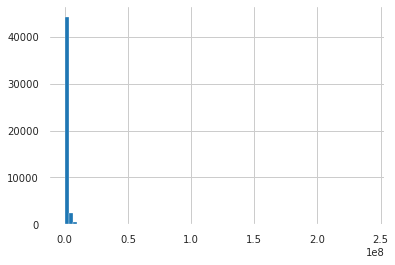

In [462]:
train['price'].hist(bins=77)
train.price.describe()

### Объединение данных

In [463]:
# для корректной обработки признаков объединяем трейн и тест в один датасет.
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

# объединяем данные
data = test.append(train, sort=False).reset_index(drop=True)


print('Размерность финального датасета:', data.shape)
data.head(2)

Размерность финального датасета: (81918, 47)


,body_type,brand,color,complectation_dict,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,model_date,number_doors,production_date,transmission,vendor,car_owners,pts,drive_type,wheel,pop_color,new,full,bargain,dealer,exchange,urgent,discount,extra,tires,rims,heating,service_incl,central_lock,power_windows,computer,airbag,power_steering,cruise_control,parking_sensors,child_car_seat,good,perfect,very_good,price_segment,car_age,km_year,sample,price
0,лифтбек,SKODA,синий,0,1.2,105.0,36,1,272.02941,2013,5,2014,3,1,3,1,2,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8.0,38.9,0,0.0
1,лифтбек,SKODA,чёрный,0,1.6,110.0,34,1,246.09551,2017,5,2017,2,1,1,1,2,1,1,1,1,0,1,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,0,0,0,2,14.0,61.5,0,0.0


Разбивка признаков по типам

In [464]:
# объединим все полученные признаки по категориям
# sample, price исключили из списка

bin_cols = ['pts', 'wheel', 'new', 'full', 'bargain', 'dealer',
       'exchange', 'urgent', 'discount', 'extra', 'tires', 'rims', 'heating',
       'service_incl', 'central_lock', 'power_windows', 'computer', 'airbag',
       'power_steering', 'cruise_control ', 'parking_sensors', 'pop_color',
       'child_car_seat', 'good','perfect','very_good']
cat_cols = [
    'body_type', 'brand', 'color', 'fuel_type', 'transmission', 'vendor',
    'car_owners', 'drive_type','price_segment'
]
num_cols = [
    'engine_displacement', 'engine_power', 'equipment_dict', 'mileage', 'model_date', 
     'number_doors', 'production_date', 'car_age']
# len(bin_cols+cat_cols+num_cols)

In [465]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,body_type,brand,color,complectation_dict,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,model_date,number_doors,production_date,transmission,vendor,car_owners,pts,drive_type,wheel,pop_color,new,full,bargain,dealer,exchange,urgent,discount,extra,tires,rims,heating,service_incl,central_lock,power_windows,computer,airbag,power_steering,cruise_control,parking_sensors,child_car_seat,good,perfect,very_good,price_segment,car_age,km_year,sample,price
0,лифтбек,SKODA,синий,0,1.2,105.0,36,1,272.029410,2013,5,2014,3,1,3,1,2,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8.0,38.9,0,0.0
1,лифтбек,SKODA,чёрный,0,1.6,110.0,34,1,246.095510,2017,5,2017,2,1,1,1,2,1,1,1,1,0,1,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,0,0,0,2,14.0,61.5,0,0.0
2,лифтбек,SKODA,серый,1,1.8,152.0,55,1,296.647939,2013,5,2014,3,1,1,1,2,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,14.0,42.4,0,0.0
3,лифтбек,SKODA,коричневый,1,1.6,110.0,52,1,308.220700,2013,5,2014,1,1,1,1,2,1,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7.0,44.0,0,0.0
4,лифтбек,SKODA,белый,0,1.8,152.0,29,1,241.942142,2008,5,2012,1,1,1,1,2,1,1,1,1,0,1,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,0,0,0,2,13.0,26.9,0,0.0


In [466]:
# посмотрим на количество пропусков
missings = pd.DataFrame(test.isna().sum()).reset_index()
missings.rename(columns={'index': 'Переменная', 0: 'Кол-во NA'}, inplace=True)
missings

,Переменная,Кол-во NA
0,body_type,0
1,brand,0
2,color,0
3,complectation_dict,0
4,engine_displacement,0
5,engine_power,0
6,equipment_dict,0
7,fuel_type,0
8,mileage,0
9,model_date,0


### Посмотрим на распределение числовых переменных

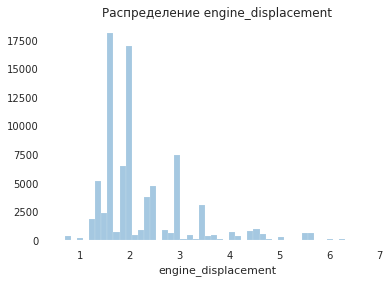

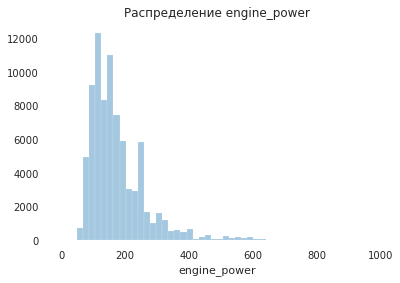

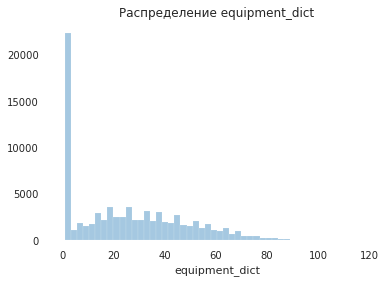

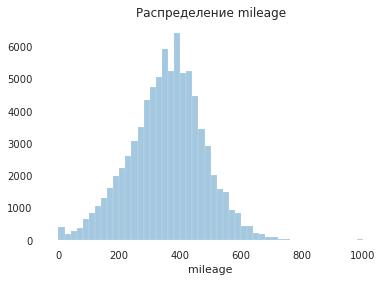

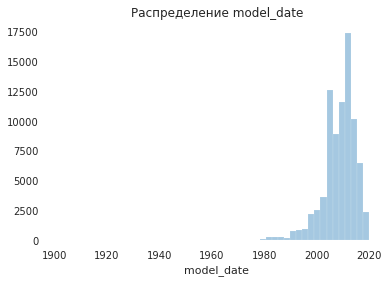

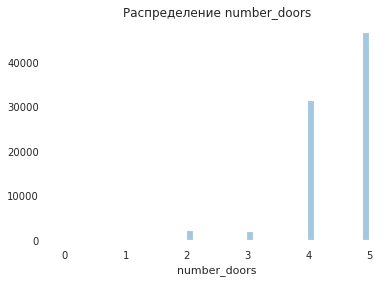

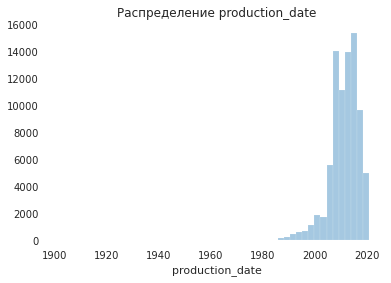

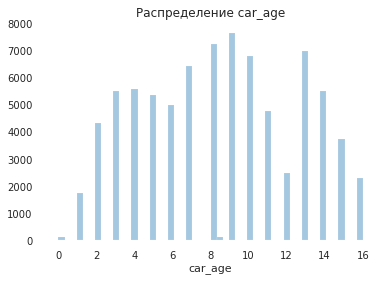

In [467]:
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

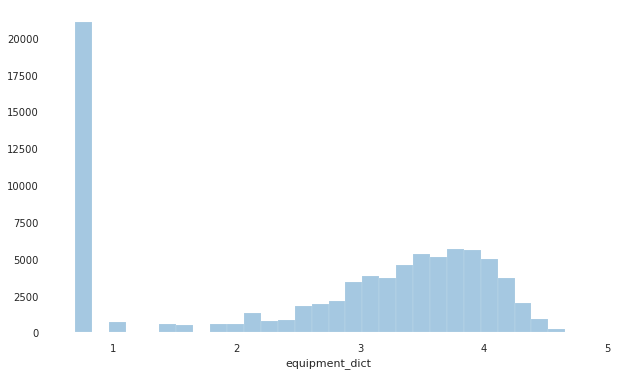

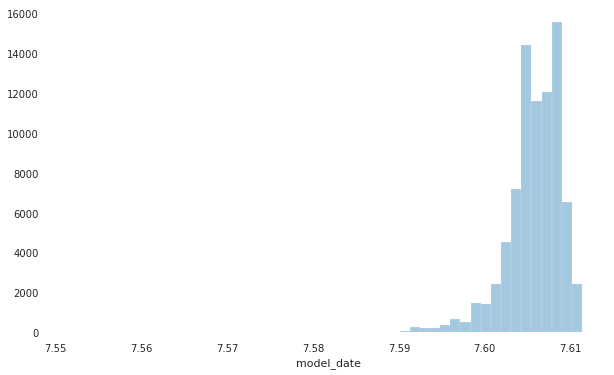

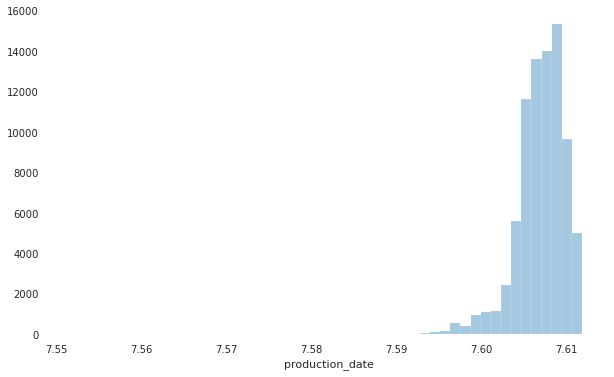

In [468]:
# прологорифмируем признаки и пробуем нормализовать их распределение
cols_log = ['equipment_dict', 'model_date', 'production_date']
for i in cols_log:
    data[i] = np.log(data[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

<AxesSubplot:>

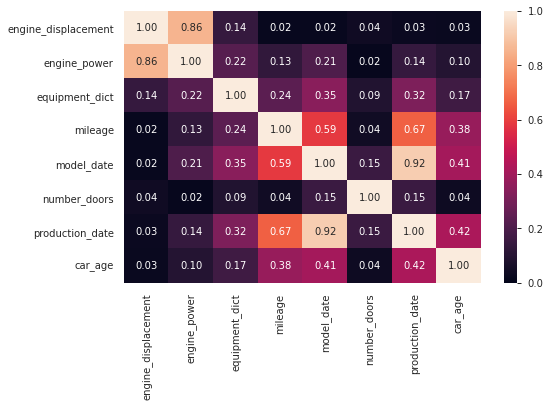

In [469]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Видно что очено сильно коррелируют между собой engine_displacement и engine_power, а также model_date и production_date .

ПО одному из этих признаков удалим. Посмотрим на их значимость.

Text(0.5, 1.0, 'Значимость числовых признаков')

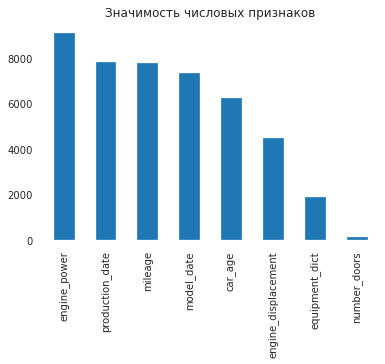

In [470]:
# используем дисперсионный анализ для определения значимости числовых признаков
imp_num = pd.Series(f_regression(data[num_cols], data["price"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
plt.title('Значимость числовых признаков')

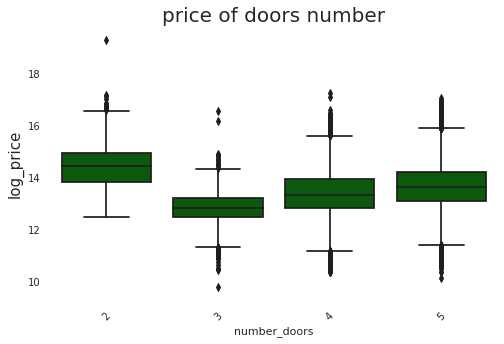

In [471]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y=np.log(train.price), x='number_doors', 
                  data=train, color='darkgreen')
g1.set_title("price of doors number", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [472]:
train[['number_doors', 'price']].corr(method='spearman')

,number_doors,price
number_doors,1.00000,0.16138
price,0.16138,1.00000


По боксплоту видна зависимость цены от количества дверей, хотя они и слабо коррелируют, поэтому этот признак не удаляем. Удалим model_date и engine_displacement из датасета.

In [473]:
data.drop('model_date', axis=1, inplace=True)
data.drop('engine_displacement', axis=1, inplace=True)

### Категориальные признаки

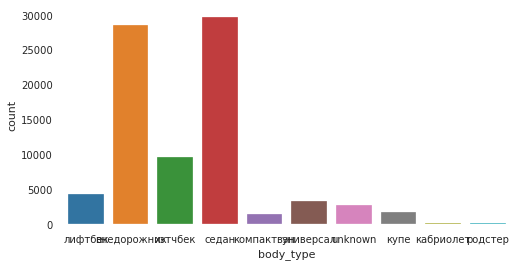

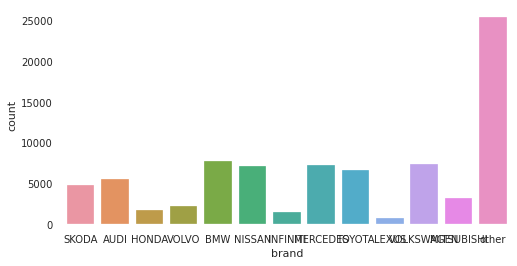

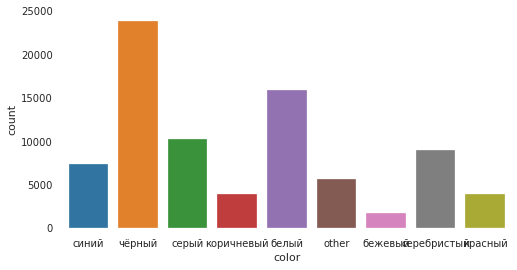

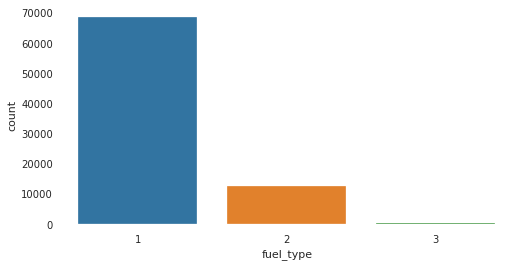

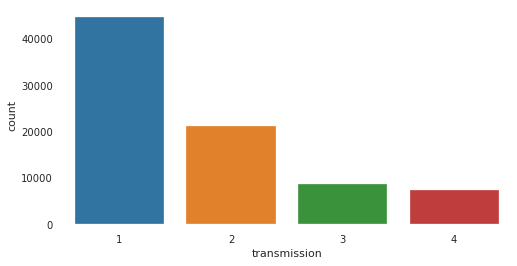

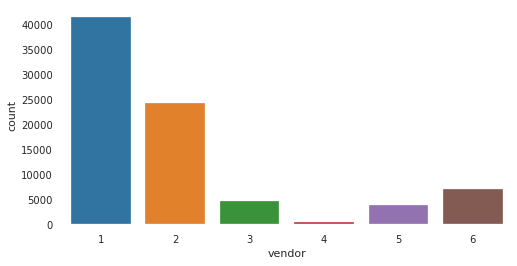

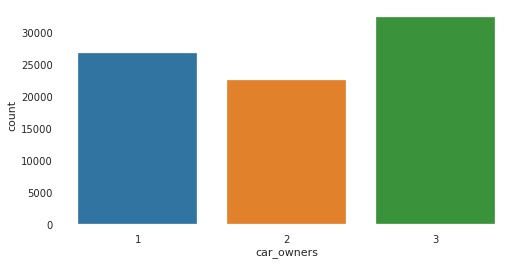

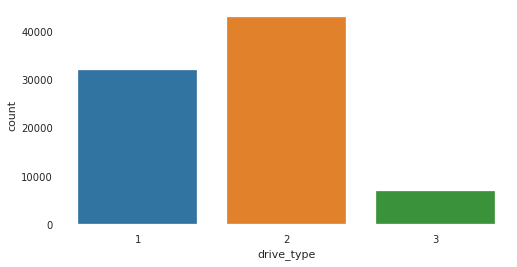

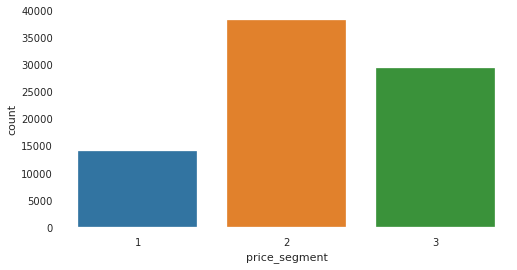

In [474]:
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col])

In [475]:
#  кодируем категориальные признаки
for column in cat_cols:
    data[column] = data[column].astype('category').cat.codes

Text(0.5, 1.0, 'Значимость категориальных признаков')

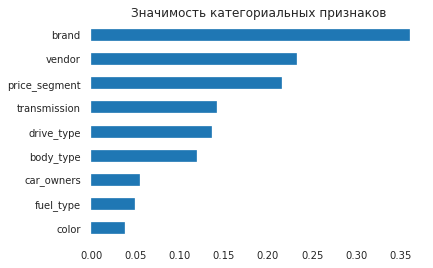

In [476]:
# определим значимость категориальных признаков
imp_cat = pd.Series(mutual_info_regression(pd.concat([data[cat_cols]], axis=1),
                                        data['price'], discrete_features =True),
                    index = pd.concat([data[cat_cols]], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Значимость категориальных признаков')

In [477]:
# корреляция категориальных признаков между собой

corr = round(data[cat_cols].corr(method='spearman'), 1)
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,body_type,brand,color,fuel_type,transmission,vendor,car_owners,drive_type,price_segment
body_type,1.000,0.100,-0.000,-0.300,0.100,0.100,0.200,0.600,-0.200
brand,0.100,1.000,-0.100,-0.100,0.100,0.500,-0.100,0.200,-0.600
color,-0.000,-0.100,1.000,0.100,-0.100,-0.100,0.000,-0.100,0.200
fuel_type,-0.300,-0.100,0.100,1.000,-0.200,-0.200,-0.100,-0.300,0.300
transmission,0.100,0.100,-0.100,-0.200,1.000,0.100,-0.000,0.100,-0.300
vendor,0.100,0.500,-0.100,-0.200,0.100,1.000,-0.100,0.100,-0.500
car_owners,0.200,-0.100,0.000,-0.100,-0.000,-0.100,1.000,0.100,0.000
drive_type,0.600,0.200,-0.100,-0.300,0.100,0.100,0.100,1.000,-0.300
price_segment,-0.200,-0.600,0.200,0.300,-0.300,-0.500,0.000,-0.300,1.000


drive_type и body_type умеренно коррелируют между собой. Оставим все признаки без изменений

### Бинарные признаки

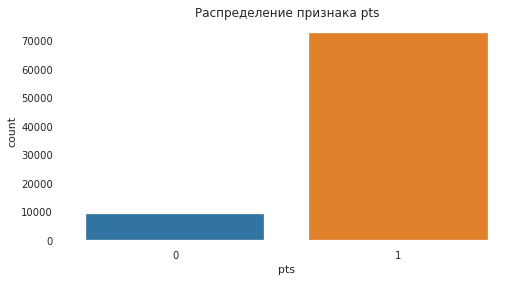

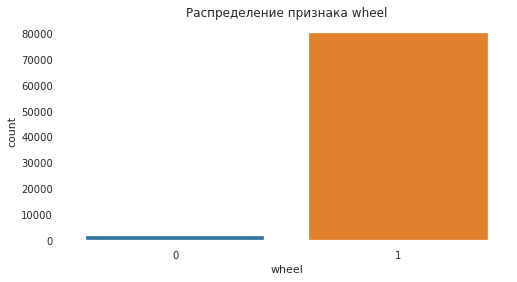

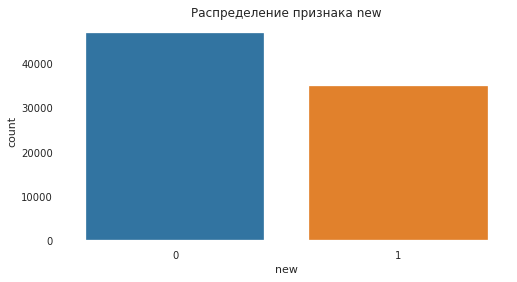

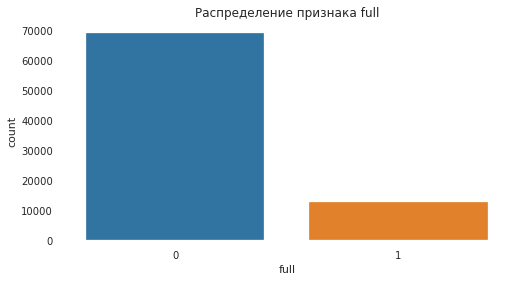

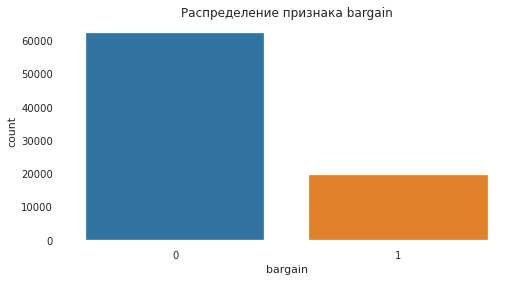

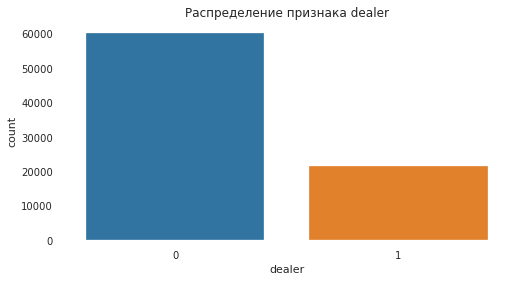

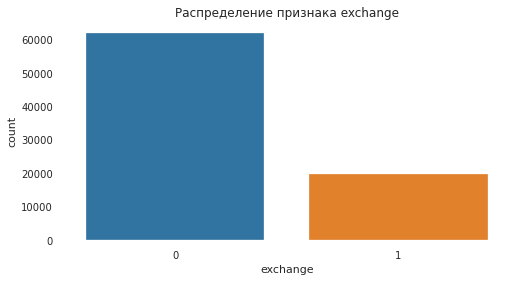

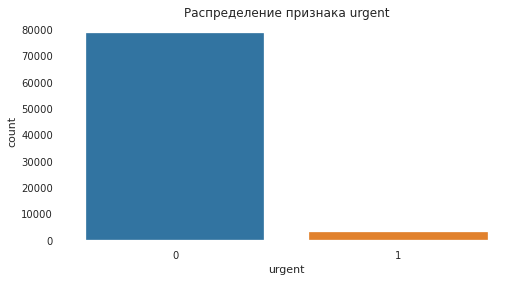

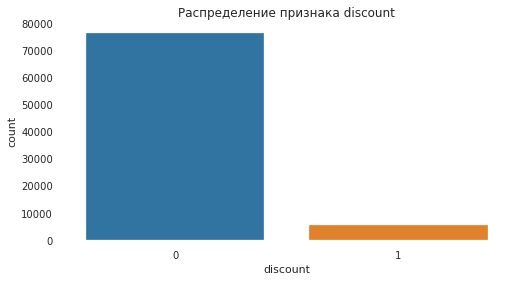

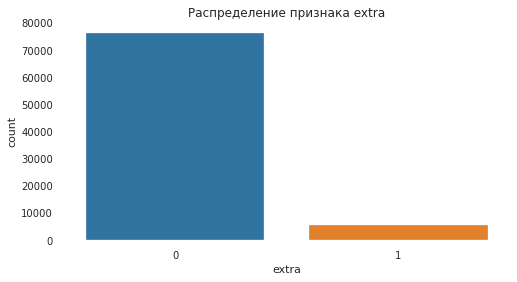

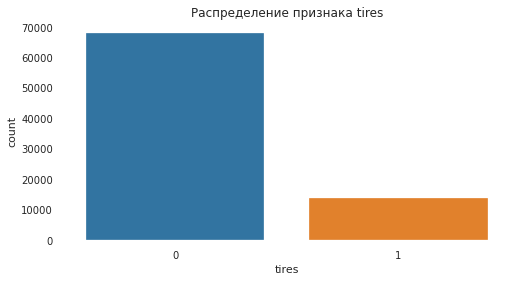

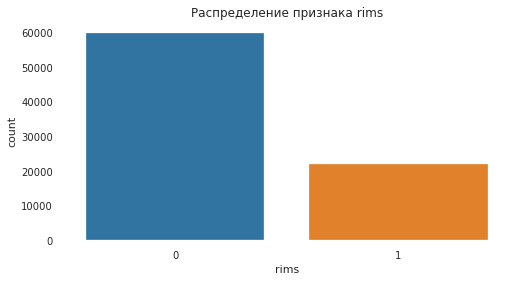

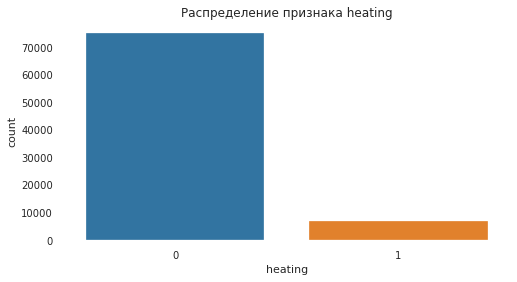

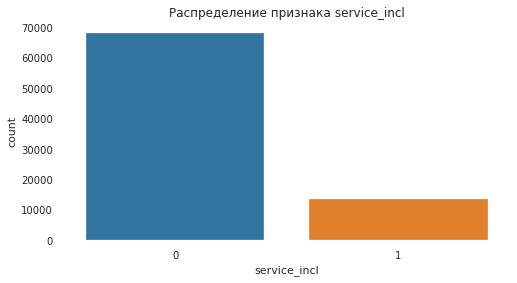

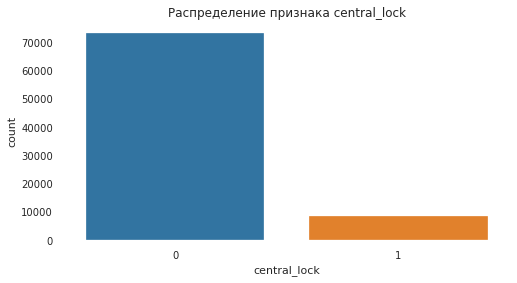

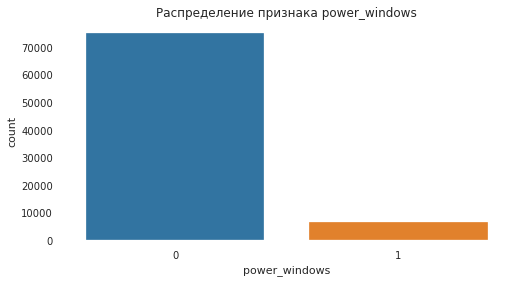

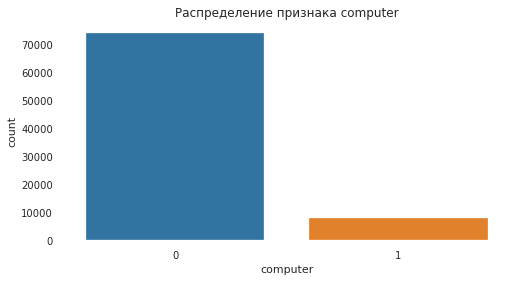

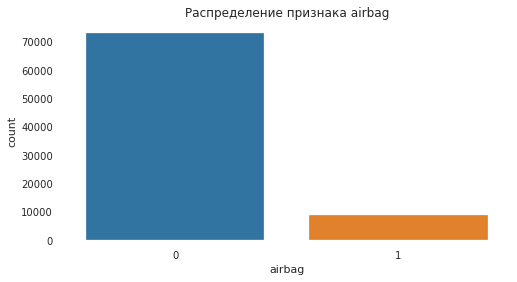

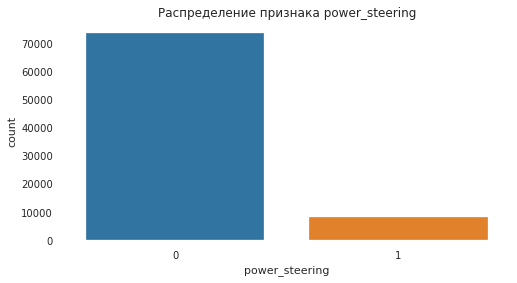

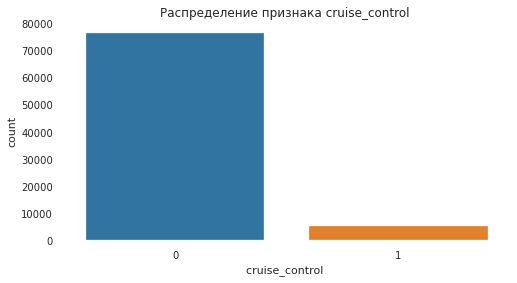

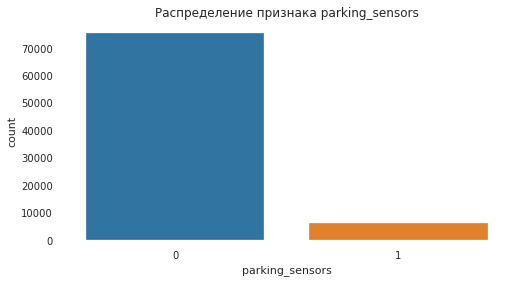

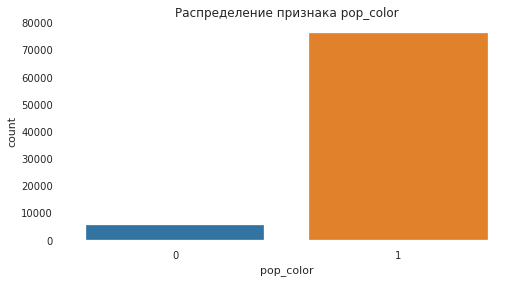

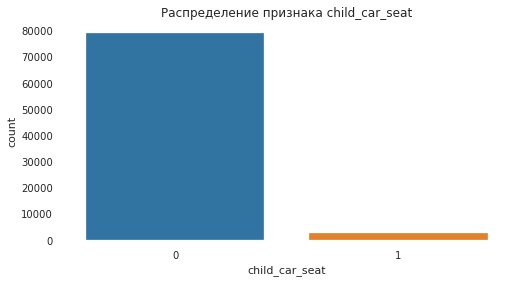

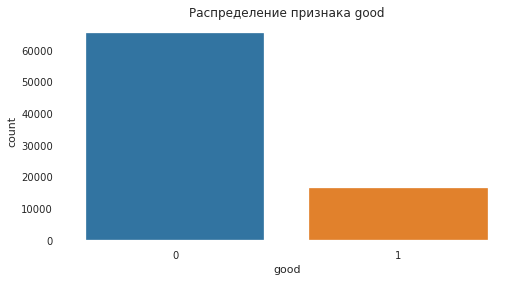

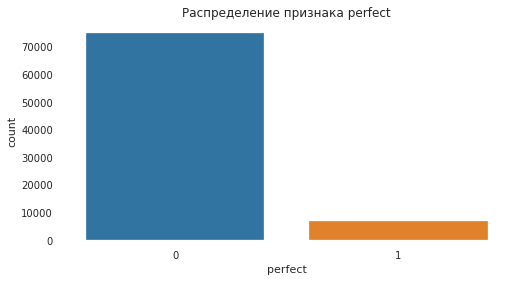

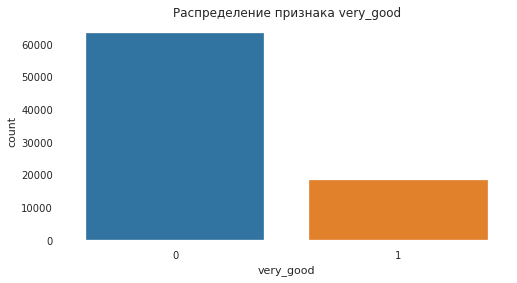

In [478]:
# посмотрим распределение бинарных признаков
for col in bin_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col])
    plt.title(f"Распределение признака {col}")

Text(0.5, 1.0, 'Значимость бинарных признаков')

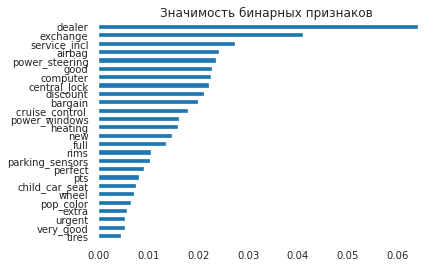

In [479]:
# значимость бинарных признаков
imp_bin = pd.Series(mutual_info_regression(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Значимость бинарных признаков')

In [480]:
# проверяем данные после преобразования
data.head(5)

,body_type,brand,color,complectation_dict,engine_power,equipment_dict,fuel_type,mileage,number_doors,production_date,transmission,vendor,car_owners,pts,drive_type,wheel,pop_color,new,full,bargain,dealer,exchange,urgent,discount,extra,tires,rims,heating,service_incl,central_lock,power_windows,computer,airbag,power_steering,cruise_control,parking_sensors,child_car_seat,good,perfect,very_good,price_segment,car_age,km_year,sample,price
0,5,8,7,0,105.0,3.610918,0,272.029410,5,7.608374,2,0,2,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.0,38.9,0,0.0
1,5,8,8,0,110.0,3.555348,0,246.095510,5,7.609862,1,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,14.0,61.5,0,0.0
2,5,8,6,1,152.0,4.025352,0,296.647939,5,7.608374,2,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14.0,42.4,0,0.0
3,5,8,3,1,110.0,3.970292,0,308.220700,5,7.608374,0,0,0,1,1,1,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7.0,44.0,0,0.0
4,5,8,2,0,152.0,3.401197,0,241.942142,5,7.607381,0,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,13.0,26.9,0,0.0


In [481]:
# for cols in ['equipment_dict', 'production_date', 'mileage']:
#     data[cols]=data[cols].round(1)

In [482]:
# разделим снова на train и test, т.к. все признаки уже обработаны
train_data = data[data['sample'] == 1].drop(['sample'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample'], axis=1)



# выделим целевую переменную и признаки
X = train_data.drop(['price'], axis=1)
y = train_data['price']


# standard scaler

# X = StandardScaler().fit_transform(X)


# разделим на тренировочные и валидационные выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# прологарифмируем целевую переменную, тренировать модель будем на ней
y_train_log = np.log(y_train)

In [483]:
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Модели

In [484]:
# функция отображения метрики модели
def print_learn_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print(f"Точность по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

### Линейная регрессия

In [485]:
start = datetime.now()

# обучим модель
model_LR = LinearRegression().fit(X_train, y_train_log)
# делаем "логарифмированое" предсказание
y_pred_log = model_LR.predict(X_test)
# приводим цену к нужному формату: экспоненциируем
y_pred = np.exp(y_pred_log)

print_learn_report(start, y_test, y_pred)


Время выполнения -  0:00:00.021424
Точность по метрике MAPE:23.61%


### RandomForest
Определим лучшие параметры и обучим на них модель

In [486]:
model_RF =  RandomForestRegressor()
model_RF.fit(X_train, np.log(y_train))
y_pred = np.exp(model_RF.predict(X_test))
print_learn_report(start, y_test, y_pred)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rfr = RandomForestRegressor(random_state = RANDOM_SEED)
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
rf_random.fit(X_train, np.log(y_train))
rf_random.best_params_


Время выполнения -  0:00:26.424658
Точность по метрике MAPE:12.48%
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 276 out of 300 | elapsed:  

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [487]:
start = datetime.now()

# best_params_: 
# {'n_estimators': 200,
# 'min_samples_split': 2,
# 'min_samples_leaf': 2,
# 'max_features': 'auto',
# 'max_depth': None,
# 'bootstrap': True}

best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=200
                      , min_samples_split=2
                      , min_samples_leaf=2
                      , max_features='auto'
                      , bootstrap=True)

best_rfr.fit(X_train, np.log(y_train))

predict_rfr = np.exp(best_rfr.predict(X_test))
print_learn_report(start, y_test, predict_rfr)


Время выполнения -  0:00:42.031564
Точность по метрике MAPE:12.43%


### LightGBM

In [488]:
for e,i in enumerate([5, 50, 250, 500, 750, 2000, 3000, 4000, 15000, 30000]):
    print(i)
    start = datetime.now()
    regr_uquipment = lgb.LGBMRegressor(n_estimators=i)
    regr_uquipment.fit(X_train,y_train_log)
    y_pred = np.exp(regr_uquipment.predict(X_test))
    print_learn_report(start, y_test, y_pred)

5

Время выполнения -  0:00:00.138009
Точность по метрике MAPE:53.60%
50

Время выполнения -  0:00:00.235695
Точность по метрике MAPE:14.43%
250

Время выполнения -  0:00:00.666838
Точность по метрике MAPE:12.41%
500

Время выполнения -  0:00:01.124112
Точность по метрике MAPE:11.99%
750

Время выполнения -  0:00:01.733357
Точность по метрике MAPE:11.88%
2000

Время выполнения -  0:00:16.802410
Точность по метрике MAPE:11.91%
3000

Время выполнения -  0:00:05.764169
Точность по метрике MAPE:11.99%
4000

Время выполнения -  0:00:21.257630
Точность по метрике MAPE:12.08%
15000

Время выполнения -  0:00:53.388856
Точность по метрике MAPE:12.37%
30000

Время выполнения -  0:01:49.737039
Точность по метрике MAPE:12.41%


In [489]:
start = datetime.now()
    
model_LGBM = lgb.LGBMRegressor(n_estimators=750)
model_LGBM.fit(X_train, np.log(y_train))

y_pred = np.exp(model_LGBM.predict(X_test))
print_learn_report(start, y_test, y_pred)


Время выполнения -  0:00:08.426960
Точность по метрике MAPE:11.88%


### XGBRegressor

In [490]:
start = datetime.now()

model_XGBR = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)
model_XGBR.fit(X_train, np.log(y_train))

y_pred = np.exp(model_XGBR.predict(X_test))
print_learn_report(start, y_test, y_pred)


Время выполнения -  0:00:33.232695
Точность по метрике MAPE:11.61%


### CatboostRegressor

In [491]:
# CATBOOST
ITERATIONS = 2000
LR         = 0.1

In [492]:
start = datetime.now()
model_CBR = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model_CBR.fit(X_train, y_train_log,
#          cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )
y_pred = np.exp(model_CBR.predict(X_test)) 
print_learn_report(start, y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0480092	test: 0.0484302	best: 0.0484302 (0)	total: 12.7ms	remaining: 25.3s
100:	learn: 0.0106662	test: 0.0108173	best: 0.0108173 (100)	total: 465ms	remaining: 8.74s
200:	learn: 0.0095727	test: 0.0098688	best: 0.0098688 (200)	total: 892ms	remaining: 7.99s
300:	learn: 0.0090559	test: 0.0094861	best: 0.0094861 (300)	total: 1.3s	remaining: 7.36s
400:	learn: 0.0086913	test: 0.0092377	best: 0.0092377 (400)	total: 2.04s	remaining: 8.13s
500:	learn: 0.0084260	test: 0.0090854	best: 0.0090854 (500)	total: 2.92s	remaining: 8.73s
600:	learn: 0.0082214	test: 0.0089825	best: 0.0089822 (598)	total: 3.79s	remaining: 8.83s
700:	learn: 0.0080520	test: 0.0089253	best: 0.0089253 (700)	total: 4.47s	remaining: 8.28s
800:	learn: 0.0078834	test: 0.0088595	best: 0.0088595 (800)	total: 5.22s	remaining: 7.81s
900:	learn: 0.0077495	test: 0.0088210	best: 0.0088210 (900)	total: 5.72s	remaining: 6.98s
1000:	learn: 0.0076075	test: 0.0087721	best: 0.0087721 (1000)	total: 6.22s	remaining: 6.21s
1100:	learn:

In [493]:
# подбираем гиперпараметры для моделей с лучшими показателями
model = CatBoostRegressor(iterations=50,
                          loss_function='MAPE',
                          metric_period=10)
# оптимальные параметры
grid = {
    'learning_rate': [0.1, 0.13, 0.14, 0.15],
    'depth': [10, 11, 12],
    'l2_leaf_reg': [7, 7.5, 8],
    'random_strength': [0.2, 0.3, 0.4]
}

grid_search_result = model.grid_search(
     grid, X=X_train, y=np.log(y_train), plot=False, verbose=False, cv=3)

grid_search_result['params']

0:	learn: 0.9000129	test: 0.8999965	best: 0.8999965 (0)	total: 20.3ms	remaining: 995ms
10:	learn: 0.3144571	test: 0.3145439	best: 0.3145439 (10)	total: 231ms	remaining: 818ms
20:	learn: 0.1108095	test: 0.1108808	best: 0.1108808 (20)	total: 433ms	remaining: 598ms
30:	learn: 0.0404257	test: 0.0403877	best: 0.0403877 (30)	total: 623ms	remaining: 382ms
40:	learn: 0.0178518	test: 0.0180624	best: 0.0180624 (40)	total: 854ms	remaining: 187ms
49:	learn: 0.0123293	test: 0.0128005	best: 0.0128005 (49)	total: 1.06s	remaining: 0us

bestTest = 0.01280052123
bestIteration = 49

0:	learn: 0.8700168	test: 0.8699954	best: 0.8699954 (0)	total: 11.9ms	remaining: 583ms
10:	learn: 0.2170732	test: 0.2171534	best: 0.2171534 (10)	total: 192ms	remaining: 680ms
20:	learn: 0.0559053	test: 0.0559214	best: 0.0559214 (20)	total: 327ms	remaining: 451ms
30:	learn: 0.0179060	test: 0.0182044	best: 0.0182044 (30)	total: 526ms	remaining: 322ms
40:	learn: 0.0113481	test: 0.0119948	best: 0.0119948 (40)	total: 777ms	remaini

30:	learn: 0.0158281	test: 0.0160619	best: 0.0160619 (30)	total: 581ms	remaining: 356ms
40:	learn: 0.0111119	test: 0.0117088	best: 0.0117088 (40)	total: 857ms	remaining: 188ms
49:	learn: 0.0101591	test: 0.0109120	best: 0.0109120 (49)	total: 1.06s	remaining: 0us

bestTest = 0.0109119934
bestIteration = 49

0:	learn: 0.8500193	test: 0.8499947	best: 0.8499947 (0)	total: 11.3ms	remaining: 551ms
10:	learn: 0.1694020	test: 0.1694372	best: 0.1694372 (10)	total: 139ms	remaining: 493ms
20:	learn: 0.0369507	test: 0.0367910	best: 0.0367910 (20)	total: 284ms	remaining: 392ms
30:	learn: 0.0140869	test: 0.0143995	best: 0.0143995 (30)	total: 497ms	remaining: 304ms
40:	learn: 0.0107041	test: 0.0114513	best: 0.0114513 (40)	total: 808ms	remaining: 177ms
49:	learn: 0.0099065	test: 0.0108312	best: 0.0108312 (49)	total: 1.07s	remaining: 0us

bestTest = 0.01083120998
bestIteration = 49

0:	learn: 0.9000129	test: 0.8999965	best: 0.8999965 (0)	total: 12.3ms	remaining: 603ms
10:	learn: 0.3149173	test: 0.314995

20:	learn: 0.0573596	test: 0.0574355	best: 0.0574355 (20)	total: 312ms	remaining: 431ms
30:	learn: 0.0191577	test: 0.0194607	best: 0.0194607 (30)	total: 503ms	remaining: 308ms
40:	learn: 0.0121309	test: 0.0128371	best: 0.0128371 (40)	total: 688ms	remaining: 151ms
49:	learn: 0.0105432	test: 0.0114631	best: 0.0114631 (49)	total: 870ms	remaining: 0us

bestTest = 0.01146305103
bestIteration = 49

0:	learn: 0.8599765	test: 0.8600827	best: 0.8600827 (0)	total: 22.5ms	remaining: 1.1s
10:	learn: 0.1919500	test: 0.1922684	best: 0.1922684 (10)	total: 143ms	remaining: 507ms
20:	learn: 0.0458879	test: 0.0459856	best: 0.0459856 (20)	total: 293ms	remaining: 405ms
30:	learn: 0.0160897	test: 0.0165945	best: 0.0165945 (30)	total: 506ms	remaining: 310ms
40:	learn: 0.0113113	test: 0.0121702	best: 0.0121702 (40)	total: 760ms	remaining: 167ms
49:	learn: 0.0102883	test: 0.0113071	best: 0.0113071 (49)	total: 986ms	remaining: 0us

bestTest = 0.01130711717
bestIteration = 49

0:	learn: 0.8499749	test: 0.850088

49:	learn: 0.0093355	test: 0.0106865	best: 0.0106865 (49)	total: 2.02s	remaining: 0us

bestTest = 0.01068651687
bestIteration = 49

0:	learn: 0.9000129	test: 0.8999965	best: 0.8999965 (0)	total: 20.1ms	remaining: 985ms
10:	learn: 0.3141518	test: 0.3143379	best: 0.3143379 (10)	total: 488ms	remaining: 1.73s
20:	learn: 0.1106572	test: 0.1108548	best: 0.1108548 (20)	total: 939ms	remaining: 1.3s
30:	learn: 0.0401218	test: 0.0402623	best: 0.0402623 (30)	total: 1.64s	remaining: 1s
40:	learn: 0.0177257	test: 0.0181706	best: 0.0181706 (40)	total: 2.58s	remaining: 566ms
49:	learn: 0.0121240	test: 0.0129060	best: 0.0129060 (49)	total: 3.56s	remaining: 0us

bestTest = 0.01290601009
bestIteration = 49

0:	learn: 0.8700168	test: 0.8699954	best: 0.8699954 (0)	total: 51.6ms	remaining: 2.53s
10:	learn: 0.2167876	test: 0.2169692	best: 0.2169692 (10)	total: 718ms	remaining: 2.54s
20:	learn: 0.0555736	test: 0.0557422	best: 0.0557422 (20)	total: 1.37s	remaining: 1.9s
30:	learn: 0.0178833	test: 0.0184200	be

20:	learn: 0.0452539	test: 0.0453291	best: 0.0453291 (20)	total: 397ms	remaining: 548ms
30:	learn: 0.0155321	test: 0.0159879	best: 0.0159879 (30)	total: 809ms	remaining: 496ms
40:	learn: 0.0108437	test: 0.0116848	best: 0.0116848 (40)	total: 1.28s	remaining: 281ms
49:	learn: 0.0097544	test: 0.0108391	best: 0.0108391 (49)	total: 1.74s	remaining: 0us

bestTest = 0.01083909912
bestIteration = 49

0:	learn: 0.8500193	test: 0.8499947	best: 0.8499947 (0)	total: 14.5ms	remaining: 710ms
10:	learn: 0.1691955	test: 0.1692842	best: 0.1692842 (10)	total: 190ms	remaining: 673ms
20:	learn: 0.0364071	test: 0.0364101	best: 0.0364101 (20)	total: 380ms	remaining: 524ms
30:	learn: 0.0138938	test: 0.0144035	best: 0.0144035 (30)	total: 826ms	remaining: 506ms
40:	learn: 0.0104291	test: 0.0113348	best: 0.0113348 (40)	total: 1.32s	remaining: 290ms
49:	learn: 0.0094898	test: 0.0106813	best: 0.0106813 (49)	total: 1.82s	remaining: 0us

bestTest = 0.01068130603
bestIteration = 49

0:	learn: 0.9000020	test: 0.90022

49:	learn: 0.0118065	test: 0.0126077	best: 0.0126077 (49)	total: 2.14s	remaining: 0us

bestTest = 0.0126077109
bestIteration = 49

0:	learn: 0.8700168	test: 0.8699954	best: 0.8699954 (0)	total: 13.4ms	remaining: 654ms
10:	learn: 0.2168994	test: 0.2170243	best: 0.2170243 (10)	total: 247ms	remaining: 877ms
20:	learn: 0.0556632	test: 0.0557296	best: 0.0557296 (20)	total: 401ms	remaining: 554ms
30:	learn: 0.0177688	test: 0.0182474	best: 0.0182474 (30)	total: 981ms	remaining: 601ms
40:	learn: 0.0107343	test: 0.0117056	best: 0.0117056 (40)	total: 1.81s	remaining: 398ms
49:	learn: 0.0093751	test: 0.0106491	best: 0.0106491 (49)	total: 2.52s	remaining: 0us

bestTest = 0.01064913105
bestIteration = 49

0:	learn: 0.8600181	test: 0.8599950	best: 0.8599950 (0)	total: 14.2ms	remaining: 697ms
10:	learn: 0.1912230	test: 0.1913425	best: 0.1913425 (10)	total: 259ms	remaining: 918ms
20:	learn: 0.0441727	test: 0.0442339	best: 0.0442339 (20)	total: 427ms	remaining: 590ms
30:	learn: 0.0148678	test: 0.015484

10:	learn: 0.1690701	test: 0.1692031	best: 0.1692031 (10)	total: 421ms	remaining: 1.49s
20:	learn: 0.0360381	test: 0.0361941	best: 0.0361941 (20)	total: 1.48s	remaining: 2.05s
30:	learn: 0.0133083	test: 0.0139535	best: 0.0139535 (30)	total: 2.98s	remaining: 1.82s
40:	learn: 0.0100021	test: 0.0111110	best: 0.0111110 (40)	total: 4.27s	remaining: 937ms
49:	learn: 0.0090347	test: 0.0105296	best: 0.0105296 (49)	total: 5.06s	remaining: 0us

bestTest = 0.0105296245
bestIteration = 49

0:	learn: 0.9000129	test: 0.8999965	best: 0.8999965 (0)	total: 29.4ms	remaining: 1.44s
10:	learn: 0.3146610	test: 0.3148096	best: 0.3148096 (10)	total: 390ms	remaining: 1.38s
20:	learn: 0.1115724	test: 0.1118172	best: 0.1118172 (20)	total: 896ms	remaining: 1.24s
30:	learn: 0.0409433	test: 0.0411247	best: 0.0411247 (30)	total: 1.4s	remaining: 858ms
40:	learn: 0.0181714	test: 0.0185789	best: 0.0185789 (40)	total: 2.08s	remaining: 456ms
49:	learn: 0.0121743	test: 0.0129474	best: 0.0129474 (49)	total: 2.79s	remainin

40:	learn: 0.0111752	test: 0.0127609	best: 0.0127609 (40)	total: 2.28s	remaining: 500ms
49:	learn: 0.0096811	test: 0.0114523	best: 0.0114523 (49)	total: 3s	remaining: 0us

bestTest = 0.01145229604
bestIteration = 49

0:	learn: 0.8599669	test: 0.8605040	best: 0.8605040 (0)	total: 81.7ms	remaining: 4s
10:	learn: 0.1915346	test: 0.1920672	best: 0.1920672 (10)	total: 299ms	remaining: 1.06s
20:	learn: 0.0450164	test: 0.0457090	best: 0.0457090 (20)	total: 879ms	remaining: 1.21s
30:	learn: 0.0152777	test: 0.0166558	best: 0.0166558 (30)	total: 1.7s	remaining: 1.04s
40:	learn: 0.0104223	test: 0.0121460	best: 0.0121460 (40)	total: 2.54s	remaining: 558ms
49:	learn: 0.0092672	test: 0.0112692	best: 0.0112692 (49)	total: 3.28s	remaining: 0us

bestTest = 0.01126919936
bestIteration = 49

0:	learn: 0.8499645	test: 0.8505399	best: 0.8505399 (0)	total: 69.1ms	remaining: 3.38s
10:	learn: 0.1687856	test: 0.1693380	best: 0.1693380 (10)	total: 365ms	remaining: 1.29s
20:	learn: 0.0362017	test: 0.0369287	best

{'depth': 12, 'l2_leaf_reg': 8, 'random_strength': 0.2, 'learning_rate': 0.15}

In [494]:
# обучаем модель с оптимальными гиперпараметрами
optimal_parameters = {
    'depth': 12,
    'l2_leaf_reg': 8,
    'random_strength': 0.2,
    'learning_rate': 0.15
}

start = datetime.now()

model_opt = CatBoostRegressor().set_params(**optimal_parameters)
model_opt.fit(X_train, np.log(y_train), verbose=False)

y_pred = np.exp(model_opt.predict(X_test))

print_learn_report(start, y_test, y_pred)


Время выполнения -  0:01:19.466957
Точность по метрике MAPE:12.02%


Подбор параметров не дал значительного улучшения и лучшие показатели так и остались у XGBRegressor модели. Её и сохраняем

In [495]:
model_XGBR.save_model('XGBRegressor.model_XGBR')

## Бэггинг

### Со случайным лесом

In [496]:
start = datetime.now()

bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print_learn_report(start, y_test, predict_bagg_rfr)


Время выполнения -  0:01:20.544378
Точность по метрике MAPE:12.70%


### C LightGBM

In [497]:
start = datetime.now()

bagg_LGBM = BaggingRegressor(model_LGBM, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_LGBM.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_LGBM.predict(X_test))
print_learn_report(start, y_test, predict_bagg_rfr)


Время выполнения -  0:00:09.452620
Точность по метрике MAPE:12.00%


### С XGB

In [498]:
start = datetime.now()

bagg_XGB = BaggingRegressor(model_XGBR, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_XGB.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_XGB.predict(X_test))
print_learn_report(start, y_test, predict_bagg_xgb)


Время выполнения -  0:01:50.709217
Точность по метрике MAPE:11.66%


### С Catboost

In [499]:
start = datetime.now()

bagg_XGB = BaggingRegressor(model_opt, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_XGB.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_XGB.predict(X_test))
print_learn_report(start, y_test, predict_bagg_xgb)

0:	learn: 0.7931327	total: 98.1ms	remaining: 1m 37s
1:	learn: 0.6960846	total: 159ms	remaining: 1m 19s
2:	learn: 0.6149483	total: 217ms	remaining: 1m 12s
3:	learn: 0.5468608	total: 288ms	remaining: 1m 11s
4:	learn: 0.4875735	total: 350ms	remaining: 1m 9s
5:	learn: 0.4389404	total: 411ms	remaining: 1m 8s
6:	learn: 0.3978037	total: 493ms	remaining: 1m 9s
7:	learn: 0.3632708	total: 553ms	remaining: 1m 8s
8:	learn: 0.3329714	total: 612ms	remaining: 1m 7s
9:	learn: 0.3085998	total: 677ms	remaining: 1m 7s
10:	learn: 0.2887423	total: 741ms	remaining: 1m 6s
11:	learn: 0.2712593	total: 803ms	remaining: 1m 6s
12:	learn: 0.2574085	total: 869ms	remaining: 1m 5s
13:	learn: 0.2458048	total: 933ms	remaining: 1m 5s
14:	learn: 0.2366114	total: 991ms	remaining: 1m 5s
15:	learn: 0.2283626	total: 1.07s	remaining: 1m 5s
16:	learn: 0.2213674	total: 1.13s	remaining: 1m 5s
17:	learn: 0.2151620	total: 1.19s	remaining: 1m 4s
18:	learn: 0.2105594	total: 1.25s	remaining: 1m 4s
19:	learn: 0.2064520	total: 1.33s	re

161:	learn: 0.1192135	total: 11.8s	remaining: 1m 1s
162:	learn: 0.1189218	total: 11.9s	remaining: 1m
163:	learn: 0.1188052	total: 11.9s	remaining: 1m
164:	learn: 0.1185312	total: 12s	remaining: 1m
165:	learn: 0.1183352	total: 12.1s	remaining: 1m
166:	learn: 0.1180947	total: 12.1s	remaining: 1m
167:	learn: 0.1178244	total: 12.2s	remaining: 1m
168:	learn: 0.1175071	total: 12.2s	remaining: 1m
169:	learn: 0.1170995	total: 12.3s	remaining: 1m
170:	learn: 0.1166332	total: 12.4s	remaining: 1m
171:	learn: 0.1165260	total: 12.5s	remaining: 1m
172:	learn: 0.1163250	total: 12.6s	remaining: 1m
173:	learn: 0.1157012	total: 12.6s	remaining: 60s
174:	learn: 0.1151976	total: 12.7s	remaining: 59.9s
175:	learn: 0.1148829	total: 12.8s	remaining: 59.8s
176:	learn: 0.1147412	total: 12.8s	remaining: 59.7s
177:	learn: 0.1144005	total: 12.9s	remaining: 59.5s
178:	learn: 0.1140548	total: 13s	remaining: 59.4s
179:	learn: 0.1137087	total: 13s	remaining: 59.3s
180:	learn: 0.1135736	total: 13.1s	remaining: 59.2s
1

323:	learn: 0.0834506	total: 24.7s	remaining: 51.5s
324:	learn: 0.0833347	total: 24.7s	remaining: 51.4s
325:	learn: 0.0832964	total: 24.8s	remaining: 51.3s
326:	learn: 0.0831043	total: 24.9s	remaining: 51.3s
327:	learn: 0.0827917	total: 25s	remaining: 51.2s
328:	learn: 0.0826647	total: 25.1s	remaining: 51.1s
329:	learn: 0.0825905	total: 25.1s	remaining: 51.1s
330:	learn: 0.0824895	total: 25.2s	remaining: 51s
331:	learn: 0.0824054	total: 25.3s	remaining: 50.9s
332:	learn: 0.0822837	total: 25.4s	remaining: 50.8s
333:	learn: 0.0821852	total: 25.5s	remaining: 50.8s
334:	learn: 0.0820232	total: 25.5s	remaining: 50.7s
335:	learn: 0.0819407	total: 25.6s	remaining: 50.6s
336:	learn: 0.0817448	total: 25.7s	remaining: 50.5s
337:	learn: 0.0816801	total: 25.8s	remaining: 50.5s
338:	learn: 0.0814035	total: 25.9s	remaining: 50.4s
339:	learn: 0.0812122	total: 25.9s	remaining: 50.3s
340:	learn: 0.0809869	total: 26s	remaining: 50.3s
341:	learn: 0.0808366	total: 26.1s	remaining: 50.2s
342:	learn: 0.0806

483:	learn: 0.0637561	total: 37.6s	remaining: 40.1s
484:	learn: 0.0637115	total: 37.7s	remaining: 40s
485:	learn: 0.0637066	total: 37.7s	remaining: 39.9s
486:	learn: 0.0635512	total: 37.8s	remaining: 39.8s
487:	learn: 0.0633945	total: 37.9s	remaining: 39.7s
488:	learn: 0.0633497	total: 37.9s	remaining: 39.7s
489:	learn: 0.0632413	total: 38s	remaining: 39.6s
490:	learn: 0.0632117	total: 38.1s	remaining: 39.5s
491:	learn: 0.0632044	total: 38.1s	remaining: 39.4s
492:	learn: 0.0630994	total: 38.2s	remaining: 39.3s
493:	learn: 0.0630387	total: 38.3s	remaining: 39.2s
494:	learn: 0.0630380	total: 38.3s	remaining: 39.1s
495:	learn: 0.0630372	total: 38.3s	remaining: 38.9s
496:	learn: 0.0630365	total: 38.3s	remaining: 38.8s
497:	learn: 0.0630358	total: 38.3s	remaining: 38.6s
498:	learn: 0.0630351	total: 38.3s	remaining: 38.5s
499:	learn: 0.0630345	total: 38.3s	remaining: 38.3s
500:	learn: 0.0630338	total: 38.3s	remaining: 38.2s
501:	learn: 0.0630332	total: 38.3s	remaining: 38s
502:	learn: 0.0630

643:	learn: 0.0530440	total: 47.4s	remaining: 26.2s
644:	learn: 0.0529791	total: 47.5s	remaining: 26.1s
645:	learn: 0.0529200	total: 47.5s	remaining: 26s
646:	learn: 0.0528843	total: 47.6s	remaining: 26s
647:	learn: 0.0527685	total: 47.7s	remaining: 25.9s
648:	learn: 0.0526497	total: 47.8s	remaining: 25.8s
649:	learn: 0.0525834	total: 47.8s	remaining: 25.8s
650:	learn: 0.0524429	total: 47.9s	remaining: 25.7s
651:	learn: 0.0523676	total: 48s	remaining: 25.6s
652:	learn: 0.0522876	total: 48.1s	remaining: 25.6s
653:	learn: 0.0522006	total: 48.1s	remaining: 25.5s
654:	learn: 0.0521894	total: 48.2s	remaining: 25.4s
655:	learn: 0.0521524	total: 48.3s	remaining: 25.3s
656:	learn: 0.0520276	total: 48.3s	remaining: 25.2s
657:	learn: 0.0520237	total: 48.4s	remaining: 25.2s
658:	learn: 0.0520235	total: 48.4s	remaining: 25.1s
659:	learn: 0.0519105	total: 48.5s	remaining: 25s
660:	learn: 0.0518193	total: 48.6s	remaining: 24.9s
661:	learn: 0.0517158	total: 48.6s	remaining: 24.8s
662:	learn: 0.051668

804:	learn: 0.0431246	total: 59.8s	remaining: 14.5s
805:	learn: 0.0430396	total: 59.9s	remaining: 14.4s
806:	learn: 0.0429894	total: 1m	remaining: 14.3s
807:	learn: 0.0428874	total: 1m	remaining: 14.3s
808:	learn: 0.0428461	total: 1m	remaining: 14.2s
809:	learn: 0.0428015	total: 1m	remaining: 14.1s
810:	learn: 0.0427241	total: 1m	remaining: 14.1s
811:	learn: 0.0426298	total: 1m	remaining: 14s
812:	learn: 0.0425733	total: 1m	remaining: 13.9s
813:	learn: 0.0425037	total: 1m	remaining: 13.8s
814:	learn: 0.0423997	total: 1m	remaining: 13.8s
815:	learn: 0.0423334	total: 1m	remaining: 13.7s
816:	learn: 0.0422786	total: 1m	remaining: 13.6s
817:	learn: 0.0422261	total: 1m	remaining: 13.5s
818:	learn: 0.0421705	total: 1m	remaining: 13.5s
819:	learn: 0.0421175	total: 1m 1s	remaining: 13.4s
820:	learn: 0.0420862	total: 1m 1s	remaining: 13.3s
821:	learn: 0.0420215	total: 1m 1s	remaining: 13.3s
822:	learn: 0.0419855	total: 1m 1s	remaining: 13.2s
823:	learn: 0.0419092	total: 1m 1s	remaining: 13.1s
8

964:	learn: 0.0349297	total: 1m 13s	remaining: 2.65s
965:	learn: 0.0348867	total: 1m 13s	remaining: 2.57s
966:	learn: 0.0348447	total: 1m 13s	remaining: 2.5s
967:	learn: 0.0347882	total: 1m 13s	remaining: 2.42s
968:	learn: 0.0347549	total: 1m 13s	remaining: 2.35s
969:	learn: 0.0347008	total: 1m 13s	remaining: 2.27s
970:	learn: 0.0346489	total: 1m 13s	remaining: 2.19s
971:	learn: 0.0345929	total: 1m 13s	remaining: 2.12s
972:	learn: 0.0345310	total: 1m 13s	remaining: 2.04s
973:	learn: 0.0345275	total: 1m 13s	remaining: 1.97s
974:	learn: 0.0344914	total: 1m 13s	remaining: 1.89s
975:	learn: 0.0344484	total: 1m 13s	remaining: 1.81s
976:	learn: 0.0343912	total: 1m 13s	remaining: 1.74s
977:	learn: 0.0343637	total: 1m 13s	remaining: 1.66s
978:	learn: 0.0343267	total: 1m 13s	remaining: 1.59s
979:	learn: 0.0342597	total: 1m 14s	remaining: 1.51s
980:	learn: 0.0342296	total: 1m 14s	remaining: 1.43s
981:	learn: 0.0341960	total: 1m 14s	remaining: 1.36s
982:	learn: 0.0341543	total: 1m 14s	remaining: 

123:	learn: 0.1252619	total: 9.56s	remaining: 1m 7s
124:	learn: 0.1250600	total: 9.64s	remaining: 1m 7s
125:	learn: 0.1247876	total: 9.71s	remaining: 1m 7s
126:	learn: 0.1241989	total: 9.77s	remaining: 1m 7s
127:	learn: 0.1238938	total: 9.84s	remaining: 1m 7s
128:	learn: 0.1236409	total: 9.9s	remaining: 1m 6s
129:	learn: 0.1231626	total: 9.96s	remaining: 1m 6s
130:	learn: 0.1227810	total: 10s	remaining: 1m 6s
131:	learn: 0.1226608	total: 10.1s	remaining: 1m 6s
132:	learn: 0.1224995	total: 10.2s	remaining: 1m 6s
133:	learn: 0.1222003	total: 10.2s	remaining: 1m 6s
134:	learn: 0.1216888	total: 10.3s	remaining: 1m 5s
135:	learn: 0.1214342	total: 10.4s	remaining: 1m 5s
136:	learn: 0.1211262	total: 10.4s	remaining: 1m 5s
137:	learn: 0.1206240	total: 10.5s	remaining: 1m 5s
138:	learn: 0.1203074	total: 10.7s	remaining: 1m 5s
139:	learn: 0.1201623	total: 10.8s	remaining: 1m 6s
140:	learn: 0.1200075	total: 10.9s	remaining: 1m 6s
141:	learn: 0.1197045	total: 11s	remaining: 1m 6s
142:	learn: 0.119

282:	learn: 0.0868925	total: 23.9s	remaining: 1m
283:	learn: 0.0867417	total: 24s	remaining: 1m
284:	learn: 0.0866088	total: 24.1s	remaining: 1m
285:	learn: 0.0863467	total: 24.2s	remaining: 1m
286:	learn: 0.0861595	total: 24.3s	remaining: 1m
287:	learn: 0.0858969	total: 24.3s	remaining: 1m
288:	learn: 0.0857120	total: 24.4s	remaining: 1m
289:	learn: 0.0855639	total: 24.5s	remaining: 60s
290:	learn: 0.0853794	total: 24.6s	remaining: 59.8s
291:	learn: 0.0851839	total: 24.6s	remaining: 59.8s
292:	learn: 0.0849270	total: 24.7s	remaining: 59.7s
293:	learn: 0.0847987	total: 24.8s	remaining: 59.6s
294:	learn: 0.0846997	total: 24.9s	remaining: 59.5s
295:	learn: 0.0846200	total: 25s	remaining: 59.4s
296:	learn: 0.0844429	total: 25s	remaining: 59.3s
297:	learn: 0.0842330	total: 25.1s	remaining: 59.2s
298:	learn: 0.0839836	total: 25.2s	remaining: 59.1s
299:	learn: 0.0838038	total: 25.3s	remaining: 59s
300:	learn: 0.0835701	total: 25.3s	remaining: 58.9s
301:	learn: 0.0834172	total: 25.4s	remainin

442:	learn: 0.0651018	total: 36.7s	remaining: 46.1s
443:	learn: 0.0649976	total: 36.8s	remaining: 46.1s
444:	learn: 0.0648521	total: 36.9s	remaining: 46s
445:	learn: 0.0647125	total: 36.9s	remaining: 45.9s
446:	learn: 0.0645595	total: 37s	remaining: 45.8s
447:	learn: 0.0644840	total: 37.1s	remaining: 45.7s
448:	learn: 0.0644467	total: 37.2s	remaining: 45.6s
449:	learn: 0.0643659	total: 37.2s	remaining: 45.5s
450:	learn: 0.0642905	total: 37.3s	remaining: 45.4s
451:	learn: 0.0642133	total: 37.4s	remaining: 45.3s
452:	learn: 0.0641057	total: 37.5s	remaining: 45.3s
453:	learn: 0.0640272	total: 37.6s	remaining: 45.2s
454:	learn: 0.0639973	total: 37.6s	remaining: 45.1s
455:	learn: 0.0638823	total: 37.7s	remaining: 45s
456:	learn: 0.0637656	total: 37.8s	remaining: 44.9s
457:	learn: 0.0635948	total: 37.9s	remaining: 44.8s
458:	learn: 0.0635448	total: 38s	remaining: 44.7s
459:	learn: 0.0633967	total: 38s	remaining: 44.6s
460:	learn: 0.0633189	total: 38.1s	remaining: 44.6s
461:	learn: 0.0632279	

602:	learn: 0.0502715	total: 49.8s	remaining: 32.8s
603:	learn: 0.0501964	total: 49.9s	remaining: 32.7s
604:	learn: 0.0501286	total: 50s	remaining: 32.7s
605:	learn: 0.0500906	total: 50.1s	remaining: 32.6s
606:	learn: 0.0500365	total: 50.2s	remaining: 32.5s
607:	learn: 0.0499574	total: 50.3s	remaining: 32.4s
608:	learn: 0.0499053	total: 50.4s	remaining: 32.3s
609:	learn: 0.0498196	total: 50.5s	remaining: 32.3s
610:	learn: 0.0497345	total: 50.6s	remaining: 32.2s
611:	learn: 0.0496804	total: 50.6s	remaining: 32.1s
612:	learn: 0.0496311	total: 50.7s	remaining: 32s
613:	learn: 0.0495770	total: 50.8s	remaining: 31.9s
614:	learn: 0.0495144	total: 50.9s	remaining: 31.9s
615:	learn: 0.0494495	total: 51s	remaining: 31.8s
616:	learn: 0.0493470	total: 51s	remaining: 31.7s
617:	learn: 0.0492192	total: 51.1s	remaining: 31.6s
618:	learn: 0.0491658	total: 51.2s	remaining: 31.5s
619:	learn: 0.0490971	total: 51.2s	remaining: 31.4s
620:	learn: 0.0490794	total: 51.3s	remaining: 31.3s
621:	learn: 0.049047

764:	learn: 0.0412015	total: 1m 1s	remaining: 19s
765:	learn: 0.0411502	total: 1m 2s	remaining: 19s
766:	learn: 0.0411214	total: 1m 2s	remaining: 18.9s
767:	learn: 0.0410703	total: 1m 2s	remaining: 18.8s
768:	learn: 0.0410161	total: 1m 2s	remaining: 18.7s
769:	learn: 0.0409677	total: 1m 2s	remaining: 18.6s
770:	learn: 0.0408898	total: 1m 2s	remaining: 18.5s
771:	learn: 0.0408586	total: 1m 2s	remaining: 18.5s
772:	learn: 0.0408446	total: 1m 2s	remaining: 18.4s
773:	learn: 0.0408144	total: 1m 2s	remaining: 18.3s
774:	learn: 0.0408042	total: 1m 2s	remaining: 18.2s
775:	learn: 0.0407887	total: 1m 2s	remaining: 18.1s
776:	learn: 0.0407724	total: 1m 2s	remaining: 18.1s
777:	learn: 0.0407668	total: 1m 2s	remaining: 18s
778:	learn: 0.0407469	total: 1m 3s	remaining: 17.9s
779:	learn: 0.0407370	total: 1m 3s	remaining: 17.8s
780:	learn: 0.0407137	total: 1m 3s	remaining: 17.7s
781:	learn: 0.0407061	total: 1m 3s	remaining: 17.6s
782:	learn: 0.0406498	total: 1m 3s	remaining: 17.5s
783:	learn: 0.0405

921:	learn: 0.0340088	total: 1m 14s	remaining: 6.29s
922:	learn: 0.0339361	total: 1m 14s	remaining: 6.21s
923:	learn: 0.0338857	total: 1m 14s	remaining: 6.12s
924:	learn: 0.0338334	total: 1m 14s	remaining: 6.04s
925:	learn: 0.0338089	total: 1m 14s	remaining: 5.96s
926:	learn: 0.0337503	total: 1m 14s	remaining: 5.88s
927:	learn: 0.0337200	total: 1m 14s	remaining: 5.8s
928:	learn: 0.0336694	total: 1m 14s	remaining: 5.72s
929:	learn: 0.0336207	total: 1m 14s	remaining: 5.64s
930:	learn: 0.0335923	total: 1m 14s	remaining: 5.56s
931:	learn: 0.0335455	total: 1m 15s	remaining: 5.48s
932:	learn: 0.0334775	total: 1m 15s	remaining: 5.4s
933:	learn: 0.0334426	total: 1m 15s	remaining: 5.32s
934:	learn: 0.0333739	total: 1m 15s	remaining: 5.23s
935:	learn: 0.0333341	total: 1m 15s	remaining: 5.15s
936:	learn: 0.0332996	total: 1m 15s	remaining: 5.07s
937:	learn: 0.0332532	total: 1m 15s	remaining: 4.99s
938:	learn: 0.0332128	total: 1m 15s	remaining: 4.91s
939:	learn: 0.0331805	total: 1m 15s	remaining: 4

79:	learn: 0.1429252	total: 7.02s	remaining: 1m 20s
80:	learn: 0.1424619	total: 7.08s	remaining: 1m 20s
81:	learn: 0.1419352	total: 7.16s	remaining: 1m 20s
82:	learn: 0.1415125	total: 7.22s	remaining: 1m 19s
83:	learn: 0.1409455	total: 7.29s	remaining: 1m 19s
84:	learn: 0.1404446	total: 7.35s	remaining: 1m 19s
85:	learn: 0.1401631	total: 7.43s	remaining: 1m 18s
86:	learn: 0.1397204	total: 7.5s	remaining: 1m 18s
87:	learn: 0.1392542	total: 7.57s	remaining: 1m 18s
88:	learn: 0.1386657	total: 7.64s	remaining: 1m 18s
89:	learn: 0.1382816	total: 7.7s	remaining: 1m 17s
90:	learn: 0.1379435	total: 7.76s	remaining: 1m 17s
91:	learn: 0.1376610	total: 7.82s	remaining: 1m 17s
92:	learn: 0.1372405	total: 7.89s	remaining: 1m 16s
93:	learn: 0.1367931	total: 7.95s	remaining: 1m 16s
94:	learn: 0.1363397	total: 8.01s	remaining: 1m 16s
95:	learn: 0.1359249	total: 8.07s	remaining: 1m 16s
96:	learn: 0.1354644	total: 8.13s	remaining: 1m 15s
97:	learn: 0.1350996	total: 8.2s	remaining: 1m 15s
98:	learn: 0.13

239:	learn: 0.0987406	total: 17.9s	remaining: 56.6s
240:	learn: 0.0985261	total: 17.9s	remaining: 56.5s
241:	learn: 0.0985233	total: 18s	remaining: 56.2s
242:	learn: 0.0985207	total: 18s	remaining: 55.9s
243:	learn: 0.0982614	total: 18s	remaining: 55.9s
244:	learn: 0.0982588	total: 18s	remaining: 55.6s
245:	learn: 0.0982564	total: 18s	remaining: 55.3s
246:	learn: 0.0982540	total: 18s	remaining: 55s
247:	learn: 0.0981014	total: 18.1s	remaining: 55s
248:	learn: 0.0979875	total: 18.2s	remaining: 54.9s
249:	learn: 0.0979852	total: 18.2s	remaining: 54.6s
250:	learn: 0.0977148	total: 18.3s	remaining: 54.6s
251:	learn: 0.0977127	total: 18.3s	remaining: 54.3s
252:	learn: 0.0977106	total: 18.3s	remaining: 54s
253:	learn: 0.0977086	total: 18.3s	remaining: 53.7s
254:	learn: 0.0977066	total: 18.3s	remaining: 53.5s
255:	learn: 0.0973728	total: 18.4s	remaining: 53.4s
256:	learn: 0.0971822	total: 18.5s	remaining: 53.4s
257:	learn: 0.0970574	total: 18.5s	remaining: 53.3s
258:	learn: 0.0967281	total: 1

400:	learn: 0.0783622	total: 27.5s	remaining: 41.1s
401:	learn: 0.0782415	total: 27.6s	remaining: 41.1s
402:	learn: 0.0781098	total: 27.7s	remaining: 41s
403:	learn: 0.0780429	total: 27.7s	remaining: 40.9s
404:	learn: 0.0779535	total: 27.8s	remaining: 40.9s
405:	learn: 0.0777345	total: 27.9s	remaining: 40.8s
406:	learn: 0.0775377	total: 27.9s	remaining: 40.7s
407:	learn: 0.0772719	total: 28s	remaining: 40.6s
408:	learn: 0.0771897	total: 28.1s	remaining: 40.6s
409:	learn: 0.0771893	total: 28.1s	remaining: 40.4s
410:	learn: 0.0770686	total: 28.2s	remaining: 40.4s
411:	learn: 0.0769887	total: 28.2s	remaining: 40.3s
412:	learn: 0.0767990	total: 28.3s	remaining: 40.2s
413:	learn: 0.0766464	total: 28.3s	remaining: 40.1s
414:	learn: 0.0764095	total: 28.4s	remaining: 40.1s
415:	learn: 0.0762425	total: 28.5s	remaining: 40s
416:	learn: 0.0761465	total: 28.6s	remaining: 40s
417:	learn: 0.0760883	total: 28.7s	remaining: 39.9s
418:	learn: 0.0760188	total: 28.7s	remaining: 39.8s
419:	learn: 0.075786

560:	learn: 0.0626244	total: 38.7s	remaining: 30.3s
561:	learn: 0.0625431	total: 38.8s	remaining: 30.3s
562:	learn: 0.0624795	total: 38.9s	remaining: 30.2s
563:	learn: 0.0623974	total: 39s	remaining: 30.2s
564:	learn: 0.0622875	total: 39.1s	remaining: 30.1s
565:	learn: 0.0621545	total: 39.2s	remaining: 30.1s
566:	learn: 0.0620997	total: 39.3s	remaining: 30s
567:	learn: 0.0620287	total: 39.4s	remaining: 30s
568:	learn: 0.0619791	total: 39.5s	remaining: 29.9s
569:	learn: 0.0618927	total: 39.6s	remaining: 29.8s
570:	learn: 0.0617919	total: 39.7s	remaining: 29.8s
571:	learn: 0.0617361	total: 39.8s	remaining: 29.8s
572:	learn: 0.0616007	total: 39.9s	remaining: 29.7s
573:	learn: 0.0614465	total: 40s	remaining: 29.7s
574:	learn: 0.0613238	total: 40.1s	remaining: 29.6s
575:	learn: 0.0612267	total: 40.2s	remaining: 29.6s
576:	learn: 0.0611491	total: 40.3s	remaining: 29.6s
577:	learn: 0.0610298	total: 40.5s	remaining: 29.6s
578:	learn: 0.0609339	total: 40.6s	remaining: 29.5s
579:	learn: 0.060858

719:	learn: 0.0508386	total: 51.2s	remaining: 19.9s
720:	learn: 0.0507538	total: 51.3s	remaining: 19.9s
721:	learn: 0.0507171	total: 51.4s	remaining: 19.8s
722:	learn: 0.0506902	total: 51.5s	remaining: 19.7s
723:	learn: 0.0506137	total: 51.5s	remaining: 19.6s
724:	learn: 0.0505461	total: 51.6s	remaining: 19.6s
725:	learn: 0.0504640	total: 51.7s	remaining: 19.5s
726:	learn: 0.0503777	total: 51.8s	remaining: 19.4s
727:	learn: 0.0503689	total: 51.8s	remaining: 19.4s
728:	learn: 0.0502962	total: 51.9s	remaining: 19.3s
729:	learn: 0.0502703	total: 52s	remaining: 19.2s
730:	learn: 0.0501814	total: 52.1s	remaining: 19.2s
731:	learn: 0.0501141	total: 52.1s	remaining: 19.1s
732:	learn: 0.0500907	total: 52.2s	remaining: 19s
733:	learn: 0.0500589	total: 52.3s	remaining: 19s
734:	learn: 0.0500508	total: 52.4s	remaining: 18.9s
735:	learn: 0.0500208	total: 52.5s	remaining: 18.8s
736:	learn: 0.0499870	total: 52.5s	remaining: 18.7s
737:	learn: 0.0498557	total: 52.6s	remaining: 18.7s
738:	learn: 0.0497

881:	learn: 0.0419532	total: 1m 3s	remaining: 8.55s
882:	learn: 0.0419519	total: 1m 4s	remaining: 8.48s
883:	learn: 0.0419506	total: 1m 4s	remaining: 8.41s
884:	learn: 0.0418977	total: 1m 4s	remaining: 8.34s
885:	learn: 0.0418159	total: 1m 4s	remaining: 8.27s
886:	learn: 0.0418146	total: 1m 4s	remaining: 8.2s
887:	learn: 0.0418134	total: 1m 4s	remaining: 8.12s
888:	learn: 0.0418123	total: 1m 4s	remaining: 8.05s
889:	learn: 0.0417628	total: 1m 4s	remaining: 7.98s
890:	learn: 0.0417551	total: 1m 4s	remaining: 7.91s
891:	learn: 0.0417079	total: 1m 4s	remaining: 7.84s
892:	learn: 0.0417068	total: 1m 4s	remaining: 7.76s
893:	learn: 0.0416953	total: 1m 4s	remaining: 7.69s
894:	learn: 0.0416581	total: 1m 4s	remaining: 7.62s
895:	learn: 0.0416041	total: 1m 5s	remaining: 7.55s
896:	learn: 0.0415776	total: 1m 5s	remaining: 7.48s
897:	learn: 0.0415134	total: 1m 5s	remaining: 7.4s
898:	learn: 0.0414350	total: 1m 5s	remaining: 7.33s
899:	learn: 0.0413315	total: 1m 5s	remaining: 7.26s
900:	learn: 0.

В результате применения бэггинга результаты для Random Forest Regressor, LightGBM, XGB Regressor и Catboost снизились.

## Стеккинг. Ансамбли моделей

In [506]:
start = datetime.now()

estimators=[('lgbm', lgb.LGBMRegressor(n_estimators=2000
                                        ,random_state=RANDOM_SEED))
            ,('catboost', CatBoostRegressor(iterations = 2000
                                        ,random_seed = RANDOM_SEED
                                        ,eval_metric='MAPE'
                                        ,silent=True
                                        ,learning_rate=0.15
                                        ,depth=12
                                        ,l2_leaf_reg=8
                                        ,random_strength=0.2))]

st_ensemble_lcx = StackingRegressor(estimators=estimators
                                ,final_estimator = xgb.XGBRegressor(objective='reg:squarederror'
                                                                ,colsample_bytree=0.5
                                                                ,learning_rate=0.05
                                                                , max_depth=12
                                                                , alpha=1
                                                                ,n_estimators=1000))

    
st_ensemble_lcx.fit(X_train, np.log(y_train))

predict_ensemble_lcx = np.exp(st_ensemble_lcx.predict(X_test))
print_learn_report(start, y_test, predict_ensemble_lcx)


Время выполнения -  0:17:16.881004
Точность по метрике MAPE:12.02%


In [507]:
start = datetime.now()

estimators=[('lgbm', lgb.LGBMRegressor(n_estimators=2000
                                        ,random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror'
                                      ,colsample_bytree=0.5
                                      ,learning_rate=0.05
                                      ,max_depth=12
                                      ,alpha=1
                                      ,n_estimators=1000))]

st_ensemble_lxs = StackingRegressor(estimators=estimators
                                ,final_estimator = CatBoostRegressor(iterations = 2000
                                                                     ,random_seed = RANDOM_SEED
                                                                     ,eval_metric='MAPE'
                                                                     ,silent=True
                                                                     ,learning_rate=0.15
                                                                     ,depth=12
                                                                     ,l2_leaf_reg=8
                                                                     ,random_strength=0.2))

    
st_ensemble_lxs.fit(X_train, np.log(y_train))

predict_ensemble_lxs = np.exp(st_ensemble_lxs.predict(X_test))
print_learn_report(start, y_test, predict_ensemble_lxs)


Время выполнения -  0:05:48.281971
Точность по метрике MAPE:12.09%


Стекинг также не улучшил результаты

## Submission

In [502]:
X_sub = X_sub.drop(['price'], axis=1)

In [503]:
predict_submission = np.exp(model_XGBR.predict(X_sub))
predict_submission

array([ 586858.75,  732343.9 ,  682034.56, ...,  485368.53, 1747490.9 ,
       1177742.2 ], dtype=float32)

In [504]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission2.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.868588e+05
1,1100549428,7.323439e+05
2,1100658222,6.820346e+05
3,1100937408,7.110329e+05
4,1101037972,7.184209e+05
5,1100912634,8.215460e+05
6,1101228730,7.168331e+05
7,1100165896,4.400754e+05
8,1100768262,1.383219e+06
9,1101218501,1.165813e+06


In [508]:
predict_submission = np.exp(st_ensemble_lcx.predict(X_sub))
predict_submission

array([ 610199.2 ,  832597.06,  720116.5 , ...,  459887.56, 1647681.  ,
       1131129.6 ], dtype=float32)

In [509]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission2.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.101992e+05
1,1100549428,8.325971e+05
2,1100658222,7.201165e+05
3,1100937408,6.925464e+05
4,1101037972,7.501171e+05
5,1100912634,8.173954e+05
6,1101228730,7.327491e+05
7,1100165896,4.533328e+05
8,1100768262,1.350540e+06
9,1101218501,1.092965e+06


In [510]:
predict_submission = np.exp(st_ensemble_lxs.predict(X_sub))
predict_submission

array([ 615953.17337591,  705494.77974304,  617913.87672126, ...,
        432988.07636593, 1832314.85367771, 1166635.1129435 ])

In [511]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission3.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.159532e+05
1,1100549428,7.054948e+05
2,1100658222,6.179139e+05
3,1100937408,7.213818e+05
4,1101037972,7.053809e+05
5,1100912634,7.921310e+05
6,1101228730,7.155042e+05
7,1100165896,4.517059e+05
8,1100768262,1.648534e+06
9,1101218501,1.124500e+06


In [513]:
predict_submission = np.exp(model_opt.predict(X_sub))
predict_submission


array([ 599735.74391963,  719653.99455585,  623941.11185013, ...,
        559127.65858602, 1775677.36342201, 1153667.51891465])

In [515]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission4.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.997357e+05
1,1100549428,7.196540e+05
2,1100658222,6.239411e+05
3,1100937408,7.236166e+05
4,1101037972,6.855428e+05
5,1100912634,9.005677e+05
6,1101228730,6.901747e+05
7,1100165896,4.570190e+05
8,1100768262,1.023869e+06
9,1101218501,1.284743e+06


## Выводы

Данные - это набор характеристик автомобилей, выставленных на продажу: марка, тип кузова, дата выпуска модели, объем двигателя и т.д. Цена автомобиля является целевой переменной. Тренировочный датасет сформирован с помощью парсинга данных с сайта Auto.ru. Парсинг осуществлен с учетом признаков, имеющихся в тестовом датасете, всего 34686 наблюдений, и ограничен по году выпуска с 2005 по 2021 и статусом "с пробегом", в нем отсутствуют машины с флагом "продан". Всего в собранном тренировочном датасете 47423 наблюдений. Необходимо определить лучший алгоритм для предсказания цен на автомобили, это задача логистической регрессии.

Обрабатываем тестовый датасет и подгоняем под него тренировочный, чтобы они соответствовали Чтобы категории кузова совпадали в трейне и тесте, выберем типы кузова, которые есть в тестовом датасете Мы отобрали цвета с наибольшим количеством значений, остальные причислим к категории другое. Также выделен признак - популярный цвет. Черные автомобили чаще всего оказываются самыми дорогими. В тестовом датасете меньше марок, чем в тренировочном, поэтому сформируем список из тех марок, что указаны в тесте, остальные отнесем к категории – другое.

Целевая переменная перекошена, поэтому ее прологарифмируем, его и будем предсказывать, чтобы распрделение было более нормальным, это влияет на качество предсказаний регрессии. Признаки содержат выбросы, удаляем только самые явные.

В столбце sell_id в тренировочной выборке есть дубликаты, мы их удалили. Добавлен признак - возраст автомобиля.

Большинство автомобилей в тренировочной выборке имеют возраст 3 - 10 лет,средний возраст автомобиля - примерно 7.5 лет, чем старше автомобиль, тем он дешевле.

Чем больше пробег, тем ниже цена на авто. Средний пробег - приблизительно 100к км. Есть зависимость между объемом двигателя и ценой автомобиля: чем больше объем, тем, в среднем, выше цена. Большинство автомобилей имеют мощность двигателя от 150 до 300 л.с.,чем мощнее двигатель, тем, в среднем, выше цена. Если информация о комплектации отсутствует, мы заполняли пропуски нулями.

Дополнительные характеристики из описания мы вычленили, проанализировав самые популярные, из них сделали дополнительные признаки.

Автомобили с автоматической коробкой передач стоят дороже, а с механической - дешевле. Автомобили с задним приводом стоят дороже, а с передним - дешевле. Существуют метки премиум класса напротив MERCEDES и BMW, отразили это добавив признак класса автомобиля. Мы провели многочисленные проверки работы моделей, в том числе с подобранными гиперпараметрами, пытались использовать бэггинг и стеккинг.

Кроме того, пытались учитывать экономические показатели. Так как тестовый датасет создавался в 2020 году а новый датасет 2021, цену в трейне умножили на отношение среднего курса рубля в 2020 к сегодняшнему курсу.

На основе пробега авто создавали новый признак пробег авто в год по возрасту авто - km_year. Этот признак также не улучшил показатели.

Стеккинг использовали только для лучших моделей, так как метод требует много времени для обработки. Лучший результат показала оптимизированная модель XGBRegressor. Считаю, что при сабмите нужно учитывать изменение рынка и ценообразования за последний год, минимум 10% Финальный результат метрики MAPE на лучшей модели - 11.61%

## What's next?
Что еще можно сделать, чтобы улучшить результат:

- Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
- Попробовать другие алгоритмы и библиотеки ML
- Сгенерировать новые признаки
- Подгрузить еще больше данных
- Использование Blending & Stacking не принесло ожидаемого улучшения качества предсказаний. Наилучший результат имело применение Random Forest с регуляризацией.